# Graph

We are primarily following NetKet Library. In the NetKet Module, Graph class relies on adjacency list (adj_list) to store relationships. It is a base class and specific details are created through Hypercube class. It to model n-dimensional structures.


In [ ]:
class Graph(object):
    """
    Base class for Graph.

    This class defines the structure or graph of the system.
    Graph must have an adjacency list.
    """

    def __init__(self):
        self.adj_list = None

    def set_adj_list(self, adj_list):
        self.adj_list = adj_list

class Hypercube(Graph):
    """
    This class is used to define a hypercube structure or ordered lattice in n-dimension
    """

    def __init__(self, length, dimension, pbc=True, next_nearest=False):
        """
        Construct a new hypercube

        Args:
            length: The length of the hypercube
            dimension: The dimension of the system
            pbc: True for hypercube with periodic boundary conditions or False for hypercube with open boundary conditions
            next_nearest: To include the next nearest neighbors interaction for J1-J2 model

        TODO:non-squared hypercube
        """
        Graph.__init__(self)
        self.length = length
        self.dimension = dimension
        self.num_points = self.length ** self.dimension
        self.pbc = pbc
        self.next_nearest = next_nearest

        self.adj_list = self._create_adj_list()
        if self.next_nearest:
            self.adj_list_next = self._create_adj_list_next()

        self.num_bonds, self.bonds = self._find_bonds()
        if self.next_nearest:
            self.num_bonds_next, self.bonds_next = self._find_bonds_next()

    def _create_adj_list(self):
        """
            Create adjacency list for each point in the hypercube
        """
        adj_list = [[] for i in range(self.num_points)]
        for p in range(self.num_points):
            p_coordinate = self._point_to_coordinate(p)
            for d in range(self.dimension):
                neighbor1 = list(p_coordinate)
                neighbor2 = list(p_coordinate)
                if self.pbc or (not self.pbc and p_coordinate[d] + 1 < self.length):
                    neighbor1[d] = (p_coordinate[d] + 1) % self.length
                    adj_list[p].append(self._coordinate_to_point(neighbor1))
                if self.pbc or (not self.pbc and p_coordinate[d] - 1 >= 0):
                    neighbor2[d] = (p_coordinate[d] - 1 + self.length) % self.length
                    adj_list[p].append(self._coordinate_to_point(neighbor2))

        return adj_list

    def _create_adj_list_next(self):
        """
            Create adjacency list of the next nearest neighbour for
            each point in the hypercube.

            TODO: does not work for general dimension
        """
        adj_list = [[] for i in range(self.num_points)]

        if self.dimension == 1:
            for p in range(self.num_points):
                ## Convert to coordinate
                p_coordinate = self._point_to_coordinate(p)
                ## Next nearest neighbour
                for d in range(self.dimension):
                    neighbor1 = list(p_coordinate)
                    neighbor2 = list(p_coordinate)
                    if self.pbc or (not self.pbc and p_coordinate[d] + 2 < self.length):
                        neighbor1[d] = (p_coordinate[d] + 2) % self.length
                        adj_list[p].append(self._coordinate_to_point(neighbor1))
                    if self.pbc or (not self.pbc and p_coordinate[d] - 2 >= 0):
                        neighbor2[d] = (p_coordinate[d] - 2 + self.length) % self.length
                        adj_list[p].append(self._coordinate_to_point(neighbor2))

        else:
            ## Generate all possible next nearest neighbours coordinate
            binary = [format(a, "#0%db" % (self.dimension+2))[2:] for a in range(2 ** self.dimension)]
            array_directions = [[1 if b == '1' else -1 for b in bin] for bin in binary]

            for p in range(self.num_points):
                ## Convert to coordinate
                p_coordinate = self._point_to_coordinate(p)
                ## Next nearest neighbour
                for dir in array_directions:
                    neighbor = list(p_coordinate)
                    for d, dim in enumerate(dir):
                        process = False
                        if dim == 1 and (self.pbc or (not self.pbc and p_coordinate[d] + 1 < self.length)):
                            process = True
                            neighbor[d] = (p_coordinate[d] + 1) % self.length
                        if dim == -1 and (self.pbc or (not self.pbc and p_coordinate[d] - 1 >= 0)):
                            process = True
                            neighbor[d] = (p_coordinate[d] - 1 + self.length) % self.length

                        if not process:
                            break

                    ## Only accepted if process is true
                    if process:
                        adj_list[p].append(self._coordinate_to_point(neighbor))


        return adj_list

    def _find_bonds(self):
        """
            Create bonds for each point. Similar to adjacency list
            but no repetition is calculated.
        """
        num_bonds = 0
        bonds = []
        for i in range(self.num_points):
            for j in self.adj_list[i]:
                if j > i:
                    num_bonds += 1
                    bonds.append((i, j))

        return num_bonds, bonds

    def _find_bonds_next(self):
        """
            Create bonds for each point next nearest neighbors.
            Similar to adjacency list but no repetition is calculated.
        """
        num_bonds = 0
        bonds = []
        for i in range(self.num_points):
            for j in self.adj_list_next[i]:
                if j > i:
                    num_bonds += 1
                    bonds.append((i, j))

        return num_bonds, bonds

    def _point_to_coordinate(self, point):
        """
            Convert a given point to a coordinate based on row-major order
        """
        assert point < self.num_points
        coordinate = []
        for i in reversed(range(self.dimension)):
            v = self.length ** i
            coordinate.append(point // v)
            point = point % v

        return list(reversed(coordinate))

    def _coordinate_to_point(self, coordinate):
        """
            Convert a given coordinate to a point based on row-major order
        """
        assert len(coordinate) == self.dimension
        point = 0
        for i in range(self.dimension):
            point += coordinate[i] * (self.length ** i)

        return point



## Sample Use

For spin 1/2, N = 2 Spins, we have a square structure:
$$
\begin{bmatrix}
0 & 1 \\
2 & 3 \\
\end{bmatrix}
$$

If periodic is `False`, then each of the link is counted once so that matrix is 2 x 2. If it is true, then each neighbor is counted twice and adjecy matrix becomes 4 x 4. The nearest neighbors and the next-nearest bonds are also counted twice then.



In [ ]:
# Example: Create a 3D hypercube with size 2 (each dimension length = 2)
hypercube_graph = Hypercube(length=2, dimension=1, pbc=True, next_nearest=True)

print("Adjacency List:")
print(hypercube_graph.adj_list)

print("\nBonds:")
print(hypercube_graph.bonds)

if hypercube_graph.next_nearest:
    print("\nNext-Nearest Bonds:")
    print(hypercube_graph.bonds_next)

Adjacency List:
[[1, 1], [0, 0]]

Bonds:
[(0, 1), (0, 1)]

Next-Nearest Bonds:
[]


# Hamiltonian

## Base Class

Initialized in terms of Pauli Operators so primarily deals with those models.

In [ ]:
import numpy as np

class Hamiltonian(object):
    """
    Base class for Hamiltonian.

    This class defines the hamiltonian of the quantum many-body system.
    You must define how to get the Hamiltonian matrix.
    """

    def __init__(self, graph):
        self.graph = graph
        self.hamiltonian = None

        ## Pauli matrices
        self.SIGMA_X = np.array([[0, 1], [1, 0]])
        self.SIGMA_Y = np.array([[0, -1j], [1j, 0]])
        self.SIGMA_Z = np.array([[1, 0], [0, -1]])


    # Calculates the Hamiltonian matrix from list of samples. Returns a tensor.
    def calculate_hamiltonian_matrix(self, samples, num_samples):
        # implemented in subclass
        raise NotImplementedError

    def calculate_ratio(self, samples, machine, num_samples):
        # implemented in subclass
        raise NotImplementedError

    def diagonalize(self):
        # implemented in subclass
        raise NotImplementedError

    def diagonalize_sparse(self):
        # implemented in subclass
        raise NotImplementedError

    def get_gs_energy(self):
        """
        Get ground state energy $E_0$
        """
        if self.hamiltonian is None:
            print("Solve hamiltonian first with diagonalize()!")
        else:
            return np.real(np.min(self.eigen_values))

    def get_gs(self):
        """
        Get ground state $\Psi_{GS}$
        """
        if self.hamiltonian is None:
            print("Solve hamiltonian first with diagonalize()!")
        else:
            return self.eigen_vectors[:, np.argmin(self.eigen_values)]

    def get_gs_probability(self):
        """
        Get ground state probability $|\Psi_{GS}|^2$
        """
        if self.hamiltonian is None:
            print("Solve hamiltonian first with diagonalize()!")
        else:
            return np.abs(self.get_gs()) ** 2

    def get_full_hamiltonian(self):
        """
        Get the full Hamiltonian matrix H
        """
        if self.hamiltonian is None:
            print("Solve hamiltonian first with diagonalize()!")
        else:
            return self.hamiltonian

    def get_gs_local_energy(self):
        """
        Get the ground state local energy
        """
        if self.hamiltonian is None:
            print("Solve hamiltonian first with _diagonalize_hamiltonian!")
        else:
            gs = self.get_gs()
            eloc = np.matmul(self.hamiltonian, gs) / gs
            return eloc


## Ising Hamiltonian

The Hamiltonian assumes the form:

$$
H = h \sum_i \sigma_i^{(x)} + J \sum_i \sigma_i^{(z)} \sigma_{i+1}^{(z)}
$$

where:
- h is the coefficient for the transverse field acting on each spin along the $ x $-axis,
- J is the coupling constant for the interaction between neighboring spins along the $ z $-axis,



In [ ]:
import tensorflow as tf
import itertools
import numpy as np
import scipy
import scipy.sparse.linalg

class Ising (Hamiltonian):
    """
    This class is used to define Transverse Field Ising Hamiltonian.
    Nearest neighbor interaction along z-axis with magnitude J
    and external magnetic field along x-axis with magnitude h

    $H_I = -J \sum_{<i,j>} \sigma^z_i \sigma^z_j -h \sum_{i} \sigma^x_i $
    """

    def __init__(self, graph, j=1.0, h=1.0):
        """
        Construct an Ising model.

        Args:
            j: magnitude of the nearest neighbor interaction along z-axis
            h: magnitude of external magnetic field along x-axis
        """

        Hamiltonian.__init__(self, graph)
        self.j = j
        self.h = h

    def calculate_hamiltonian_matrix(self, samples, num_samples):
        """
        Calculate the Hamiltonian matrix $H_{x,x'}$ from a given samples x.
        Only non-zero elements are returned.

        Args:
            samples: The samples
            num_samples: number of samples

        Return:
            The Hamiltonian where the first column contains the diagonal, which is $-J \sum_{i,j} x_i x_j$.
            The rest of the column contains the off-diagonal, which is -h for every spin flip.
            Therefore, the number of column equals the number of particles + 1 and the number of rows = num_samples
        """
        # Diagonal element of the hamiltonian
        # $-J \sum_{i,j} x_i x_j$
        diagonal = tf.zeros((num_samples,))
        for (s, s_2) in self.graph.bonds:
            diagonal += -self.j * samples[:,s] * samples[:,s_2]

        diagonal = tf.reshape(diagonal, (num_samples, 1))

        ## Off-diagonal element of the hamiltonian
        ## $-h$ for every spin flip
        off_diagonal = tf.fill((num_samples, self.graph.num_points), -self.h)
        hamiltonian = tf.concat([diagonal, off_diagonal], axis=1)

        return hamiltonian

    def calculate_ratio(self, samples, model, num_samples):
        """
       Calculate the ratio of \Psi(x') and \Psi(x) from a given x
        as log(\Psi(x')) - log(\Psi(x))
       \Psi is defined in the model.
        However, the Hamiltonian determines which x' gives non-zero.

        Args:
            samples: the samples x
            model: the model used to define \Psi
            num_samples: the number of samples
        Return:
            The ratio where the first column contains \Psi(x) / \Psi(x).
            The rest of the column contains the non-zero \Psi(x') / \Psi(x).
            In the Ising model, this corresponds x' where exactly one of spin x is flipped.
            Therefore, the number of column equals the number of particles + 1 and the number of rows = num_samples

        """

        ## Calculate log(\Psi(x)) - log(\Psi(x))
        lvd = model.log_val_diff(samples, samples)

        ## Calculate log(\Psi(x')) - log(\Psi(x)) where x' is non-zero when x is flipped at one position.
        for pos in range(self.graph.num_points):
            ## Flip spin at position pos
            new_config = tf.identity(samples)
            flipped = tf.reshape(new_config[:,pos] * -1, (num_samples, 1))
            if pos == 0:
                new_config = tf.concat((flipped, samples[:,pos+1:]), axis = 1)
            elif pos == self.graph.num_points - 1:
                new_config = tf.concat((samples[:, :pos], flipped), axis = 1)
            else:
                new_config = tf.concat((samples[:, :pos], flipped, samples[:,pos+1:]), axis = 1)

            lvd = tf.concat((lvd, model.log_val_diff(new_config, samples)), axis=1)
        return lvd


    def get_name(self):
        """
        Get the name of the Hamiltonian
        """
        if self.graph.pbc:
            bc = 'pbc'
        else:
            bc = 'obc'
        return 'ising_%dd_%d_%.3f_%.3f_%s' % (
        self.graph.dimension, self.graph.length, self.h,
            self.j, bc)

    def __str__(self):
        return "Ising %dD, h=%.2f, J=%.2f" % (self.graph.dimension, self.h, self.j)



### Sample use of `calculate_hamiltonian_matrix` function

Lets try out the Ising Hamiltonian functionalies for our basic N = 2, Spin 1/2 system for which we defined the graph over. We define the Hamiltonian with parameters j = 1, h = 0.5. With each sample $s_i$ of dimension d, we have a an associated Hamiltonian output of d + 1. The first dimension gives the sum of interaction and external field while the rest of d-dimensions gives the external force felt by each of the particle.


# Sampler

We now implement samplers that sample collection of points from the underlying probability distribuition. Recall that
the expectation value of the energy $E$ for a given variational wave function $\Psi(x)$ is:

$$
E = \frac{\langle \Psi | H | \Psi \rangle}{\langle \Psi | \Psi \rangle} = \frac{\int \Psi^*(x) H \Psi(x) \, dx}{\int |\Psi(x)|^2 \, dx}
$$

Using the local energy $E_{\text{loc}}(x)$, which is defined as:

$$
E_{\text{loc}}(x) = \frac{H \Psi(x)}{\Psi(x)},
$$

we can rewrite $E$ as an expectation value of $E_{\text{loc}}(x)$ over the probability distribution $P(x) = |\Psi(x)|^2$:

$$
E = \int E_{\text{loc}}(x) \, P(x) \, dx = \mathbb{E}_{P(x)}[E_{\text{loc}}(x)].
$$

In order to draw samples from this underlying distribuition, we implement Metropolis Local.


In [ ]:
class Sampler(object):

    def __init__(self, num_samples):
        self.num_samples = num_samples

    def get_initial_random_samples(self, sample_size, num_samples=None):
        pass

    def sample(self, machine, initial_sample, num_samples):
        pass

    def set_num_samples(self, num_samples):
        self.num_samples = num_samples

    def set_num_steps(self, num_steps):
        self.num_steps = num_steps

## Gibbs.py

Gibbs sampler approximates the graident of the log-likelihood of p(v, h) which is computationally expensive to calculate exactly. As explored previous, Gibbs sampler works under the framework of contrastive divergence (CD). During CD training, Gibbs sampling is used to approximate the model’s distribution by starting from an observed data point $ v_0 $ (an actual visible unit configuration). The process is as follows. We start with a visible state $ v_0 $ (the actual data). We then perform a small number of Gibbs sampling steps (often just one or a few referred to as \( k \)-step Contrastive Divergence).
  - **Update hidden units**: Compute $ P(h|v_0) $ and sample $ h_0 $ from this distribution.
  - **Update visible units**: Compute $ P(v|h_0) $ and sample a new visible state $ v_1 $.
  - Repeat if more steps are specified.

After these Gibbs steps, we compare the starting visible state $ v_0 $ and the resulting visible state $ v_k $ from the final Gibbs step. This comparison provides the basis for adjusting the weights.



In [ ]:
import tensorflow as tf


class Gibbs(Sampler):
    """
    This class is used to do a Gibbs sampling.
    Gibbs sampling is a special case of Metropolis algorithm where acceptance ratio is 1.
    Only works for RBM machine with real positive wave function
    """

    def __init__(self, num_samples, num_steps=1):
        """
        Construct a Gibbs sampler

        Args:
            num_samples: number of samples
            num_steps: number of steps (1 step = sample h from p(h| v) and sample v from p (v|h)
        """
        Sampler.__init__(self, num_samples)
        self.num_steps = num_steps

    def get_initial_random_samples(self, sample_size, num_samples=None):
        """
            Get initial random samples with size [num_samples, sample_size]
            from a random uniform.
            Args:
                sample_size: the number of particles
                num_samples: number of samples
            Return:
                initial random samples
        """
        if num_samples is None:
            num_samples = self.num_samples

        init_data = tf.random.uniform((num_samples, sample_size), 0, 2, dtype=tf.dtypes.int32)
        init_data = tf.where(init_data == 0, -1, 1)

        return tf.cast(init_data, tf.dtypes.float32)

    def sample(self, model, initial_sample, num_samples):
        """
            Do a gibbs sampling from a given initial sample
            by sampling from p(v | h) from the RBM
            Args:
                model: model to calculate \Psi(x)
                initial_sample: the initial sample
                num_samples: number of samples returned

            Return:
                new samples
        """
        sample = initial_sample
        for i in range(self.num_steps):
            sample = model.get_new_visible(sample)

        return sample

    def get_all_samples(self, model, initial_sample, num_samples):
        """
            Get sample from gibbs sampling
        """
        all_samples = []
        sample = initial_sample
        for i in range(self.num_steps):
            sample = model.get_new_visible(sample)
            all_samples.append(sample)

        return all_samples

    def to_xml(self):
        str = ""
        str += "<sampler>\n"
        str += "\t<type>gibbs</type>\n"
        str += "\t<params>\n"
        str += "\t\t<num_samples>%d</num_samples>\n" % self.num_samples
        str += "\t\t<num_steps>%d</num_steps>\n" % self.num_steps
        str += "\t</params>\n"
        str += "</sampler>\n"
        return str

NameError: name 'Sampler' is not defined

# Model

In [ ]:
class Model(object):

    def __init__(self):
        self.num_visible = 0

    def log_val(self, v):
        pass

    def log_val_diff(self, v1, v2):
        pass

    def derlog(self, v, size):
        pass

    def get_parameters(self):
        pass

    def visualize_param(self):
        pass

    def is_complex(self):
        return False

    def is_probability(self):
        return False

## RBM Base Model

Assuming that one is familiar with RBM, we will only explain the nuances of this implementation which are not found in traditional approaches.

In [ ]:

class RBM(Model):

    def __init__(self, num_visible, density=2):
        Model.__init__(self)
        self.num_visible = num_visible
        self.density = density
        self.num_hidden = int(self.num_visible * self.density)
        self.W = None
        self.bv = None
        self.bh = None
        self.connection = None

    def is_complex(self):
        return False

    def is_real(self):
        return False

## RBM_realpos


Let us now work with the RBM-ansatz that the authors of the paper, "Solving the Quantum Many-Body Problem with Artificial Neural Networks"* utilized:

$$
\psi(\vec{s}, a, b, W) = e^{\sum_{i=1}^{N} a_i s_i} \prod_{i=1}^{M} \left[ 2 \cosh \left( \sum_{j=1}^{N} W_{ij} s_j + b_i \right) \right]
$$

Where the RBM_realpos assumes that $ a_i, W_{ij}, b_i $ are real-valued. The logarithm of the wavefunction $ \psi(\vec{s}, a, b, W) $ is given by:

$$
\ln \psi(\vec{s}, a, b, W) = \sum_{i=1}^{M} a_i s_i + \sum_{i=1}^{M} \ln \left[ 2 \cosh \left( \sum_{j=1}^{N} W_{ij} s_j + b_i \right) \right]
$$

The derivatives then become:


   $$
   \frac{\partial \ln \psi(\vec{s}, a, b, W)}{\partial a_i} = s_i
   $$

The derivative of cosh is sinh. Keeping this in mind, we have:


   $$
   \frac{\partial \ln \psi(\vec{s}, a, b, W)}{\partial b_j} = \tanh \left( \sum_{k=1}^{N} W_{jk} s_k + b_j \right)
   $$

Finally, the partial Derivative with Respect to \( W_{ij} \) is:


   $$
   \frac{\partial \ln \psi(\vec{s}, a, b, W)}{\partial W_{ij}} = s_i \tanh \left( \sum_{k=1}^{N} W_{jk} s_k + b_j \right)
   $$

Thus,

- For $ a_i $:
  $
  \frac{\partial \ln \psi(\vec{s}, a, b, W)}{\partial a_i} = s_i
  $

- For $ b_j $:
  $
  \frac{\partial \ln \psi(\vec{s}, a, b, W)}{\partial b_j} = \tanh \left( \sum_{k=1}^{N} W_{jk} s_k + b_j \right)
  $

- For $ W_{ij} $:
  $
  \frac{\partial \ln \psi(\vec{s}, a, b, W)}{\partial W_{ij}} = s_i \tanh \left( \sum_{k=1}^{N} W_{jk} s_k + b_j \right)
  $



In [ ]:
import tensorflow as tf
import copy
from functools import partial
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

class RBMRealPos(RBM):
    """
    This class is used to define a restricted Boltzmann machine with real and
    positive wavefunction and as an ansatz for |\Psi(x)|^2.

    $\Psi(x) = \sqrt(e^{ax} \times \Pi_{j=1}^{H} \cosh(W_jx + b_j))$

    where a = bv is the visible bias, b = bh is the hidden bias, and H is the number of hidden nodes.
    """


    def __init__(self, num_visible, density=2, initializer=None, use_bias=True, num_expe=None):
        """
        Construct an RBM model for real positive wavefunction
        Args:
            num_visible: number of visible
            density: the number hidden layer define as density * num_visible
            initializer: the initialization of the weights
            use_bias: use bias or not
            num_expe: number of experiment to determine the seed
        """
        RBM.__init__(self, num_visible, density)
        self.initializer = initializer
        self.use_bias = use_bias
        self.num_expe = num_expe

        if num_expe is not None:
            np.random.seed(num_expe)
            tf.random.set_seed(num_expe)

        self.build_model()

    def build_model(self):
        """
        Build the RBM model
        """
        ## Randomly initialize the weights and bias
        self.random_initialize()
        ## Create the model
        self.create_variable()

    def random_initialize(self):
        """
        Randomly initialize an array based on the initializer. Biases array are initialized zero.
        """
        ## Weights (W)
        self.W_array = self.initializer(size=(self.num_visible, self.num_hidden))
        ## Visible bias (a)
        self.bv_array = np.zeros((1, self.num_visible))
        ## Hidden bias (b)
        self.bh_array = np.zeros((1, self.num_hidden))


    def create_variable(self):
        """
        Create model by creating a parameters variable, which is the weight, visible bias, hidden bias
        """
        self.W = tf.Variable(tf.convert_to_tensor(value=self.W_array.astype(np.float32)), name="weights", trainable=True)
        self.bv = tf.Variable(tf.convert_to_tensor(value=self.bv_array.astype(np.float32)), name="visible_bias", trainable=True)
        self.bh = tf.Variable(tf.convert_to_tensor(value=self.bh_array.astype(np.float32)), name="hidden_bias", trainable=True)
        self.model = self
        self.trainable_weights = [self.W, self.bv, self.bh]

    def log_val(self, x):
        """
            Calculate log(\Psi(x)) = 0.5 * (ax + \sum_{j=1}^H log(cosh(Wx + b)))
            Args:
                x: the x
        """
        ## Calculate theta = Wx + b
        theta = tf.matmul(x, self.W) + self.bh

        ## Calculate \sum_{j=1}^H log(cosh(Wx + b))
        sum_ln_thetas = tf.reduce_sum(input_tensor=tf.math.log(tf.cosh(theta)), axis=1, keepdims=True)

        ## calculate ax
        ln_bias = tf.matmul(x, tf.transpose(a=self.bv))

        return 0.5 * (sum_ln_thetas + ln_bias)

    def log_val_diff(self, xprime, x):
        """
            Calculate log(\Psi(x')) - log(\Psi(x))
            Args:
                xprime: x'
                x: x
        """
        log_val_1 = self.log_val(xprime)
        log_val_2 = self.log_val(x)
        return log_val_1 - log_val_2

    def derlog(self, x):
        """
        Calculate $D_{W}(x) = D_{W} = (1 / \Psi(x)) * (d \Psi(x) / dW)$ where W can be the weights or the biases.
        """
        sample_size = x.shape[0]

        ## Calculate theta = Wx + b
        theta = tf.matmul(x, self.W) + self.bh

        ## D_a(x) = x
        ## D_b(x) = tanh(Wx + b)
        if self.use_bias:
            D_bv = 0.5 * x
            D_bh = 0.5 * tf.tanh(theta)
        else:
            D_bv = x * 0.0
            D_bh = tf.tanh(theta) * 0.0

        # D_W(x) = x * tanh(Wx+b)
        D_w = tf.reshape(tf.tanh(theta), (sample_size, 1, self.num_hidden)) * tf.reshape(x, (sample_size, self.num_visible, 1))
        D_bv = tf.reshape(D_bv, (sample_size, 1, self.num_visible))
        D_bh = tf.reshape(D_bh, (sample_size, 1, self.num_hidden))


        derlogs = [D_w, D_bv, D_bh]
        return derlogs

    def param_difference (self, first_param, last_param):
        """
        Calculate the difference between two parameters.
        This is equals to the sum of the mean squared difference of all parameters (weights and biases)
        """
        sum_diff = 0.
        for (par1, par2) in zip(first_param[1], last_param[1]):
            sum_diff += np.mean((par1 - par2) ** 2)

        return sum_diff

    def get_new_visible(self, v):
        """
            Get new visibile by sampling h from p(h|v) and
            then sampling v from p(v | h)
        """
        hprob = self.get_hidden_prob_given_visible(v)
        hstate = self.convert_from_prob_to_state(hprob)
        vprob = self.get_visible_prob_given_hidden(hstate)
        vstate = self.convert_from_prob_to_state(vprob)
        return vstate

    def get_hidden_prob_given_visible(self, v):
        """
            Calculate p(h | v)
        """
        return tf.sigmoid(2.0 * (tf.matmul(v, self.W) + self.bh))

    def get_visible_prob_given_hidden(self, h):
        """
            Calculate p(v | h)
        """
        return tf.sigmoid(2.0 * (tf.matmul(h, tf.transpose(a=self.W)) + self.bv))


    def convert_from_prob_to_state(self, prob):
        """
            Get state of -1 and 1 from probability
        """
        v = prob - tf.random.uniform(tf.shape(input=prob), 0, 1)
        return tf.where(tf.greater_equal(v, tf.zeros_like(v)), tf.ones_like(v), -1 * tf.ones_like(v))



    def visualize_param (self, params, path):
        """
        Visualize every parameters
        Args:
            params: the parameters that visualize
            path: the path to save the visualization
        """
        epoch = params[0]
        for ii, param in enumerate(params[1]):
            plt.figure()
            if ii == 0:
                plt.title("Weight at epoch %d" % (epoch))
            elif ii == 1:
                plt.title("Visible Bias at epoch %d" % (epoch))
            elif ii == 2:
                plt.title("Hidden Bias at epoch %d" % (epoch))

            plt.imshow(param, cmap='hot', interpolation='nearest')
            plt.xticks(np.arange(0, param.shape[1], 1.0))
            plt.yticks(np.arange(0, param.shape[0], 1.0))
            plt.colorbar()
            plt.tight_layout()
            if ii == 0:
                plt.savefig(path + '/weight-layer-%d.png' % (epoch))
            elif ii == 1:
                plt.savefig(path + '/visbias-layer-%d.png' % (epoch))
            elif ii == 2:
                plt.savefig(path + '/hidbias-layer-%d.png' % (epoch))
            plt.close()

    def get_parameters(self):
        """
        Get the parameter of this model
        """
        return [self.W.numpy(), self.bv.numpy(), self.bh.numpy()]

    def set_parameters(self, params):
        """
        Set the parameters for this model for transfer learning or loading model purposes
        Args:
            params: the parameters to be set.
        """
        self.W.assign(params[0])
        self.bv.assign(params[1])
        self.bh.assign(params[2])

    def get_name(self):
        """
        Get the name of the model
        """
        return 'rbmrealpos-%d' % (self.num_hidden)

    def make_pickle_object(self):
        """
        Make pickle object for RBM
        Nothing to do for RBM
        """
        pass

    def __str__(self):
        return 'RBMRealPos %d' % (self.num_hidden)

    def to_xml(self):
        stri = ""
        stri += "<model>\n"
        stri += "\t<type>rbm_real_pos</type>\n"
        stri += "\t<params>\n"
        stri += "\t\t<num_visible>%d</num_visible>\n" % self.num_visible
        stri += "\t\t<num_hidden>%d</num_hidden>\n" % self.num_hidden
        stri += "\t\t<density>%d</density>\n" % self.density
        stri += "\t\t<initializer>%s</initializer>\n" % str(self.initializer)
        stri += "\t\t<use_bias>%s</use_bias>\n" % str(self.use_bias)
        stri += "\t\t<num_expe>%s</num_expe>\n" % str(self.num_expe)
        stri += "\t</params>\n"
        stri += "</model>\n"
        return stri

NameError: name 'nn' is not defined

# Observables

# Learner

The learner optimizes the expectation value $$
E = \int E_{\text{loc}}(x) \, P(x) \, dx = \mathbb{E}_{P(x)}[E_{\text{loc}}(x)].
$$

From notes on Quantum Machine Learning, this comes out to be:

$$
\frac{\partial E(\alpha)}{\partial \alpha} \approx \frac{1}{M} \sum_{m=1}^M \left( \frac{\partial E_{\text{loc}}(S^{(m)}; \alpha)}{\partial \alpha} + \left( E_{\text{loc}}(S^{(m)}; \alpha) - E(\alpha) \right) \frac{\partial \ln \Psi(S^{(m)}; \alpha)}{\partial \alpha} \right)
$$

The above can be seen as consisting of three main quantities:

1. **Average of Local Energy**:
  $
  \frac{1}{M} \sum_{m=1}^M E_{\text{loc}}(S^{(m)}; \alpha)
  $

2. **Average of Log-Derivative**:
  $
  \frac{1}{M} \sum_{m=1}^M \frac{\partial \ln \Psi(S^{(m)}; \alpha)}{\partial \alpha}
  $
3. **Product of Local Energy and Log-Derivative**: $
  \frac{1}{M} \sum_{m=1}^M E_{\text{loc}}(S^{(m)}; \alpha) \cdot \frac{\partial \ln \Psi(S^{(m)}; \alpha)}{\partial \alpha}  $

Keep in mind that the above form of the derivative of the operator is called the **force-vector**.


** Note on Observables** : Let us consider how Observables are computed in context of the variational approach. In NetKet, it is the `expect` method which computes the expectation value of the operators. For example, lets say we have $ M_x $ whose expectation we would like to compute with respect to the current variational state $ \psi(\theta) $. For a pure state, this is given by: $
\langle M_x \rangle = \frac{\langle \psi(\theta) | M_x | \psi(\theta) \rangle}{\langle \psi(\theta) | \psi(\theta) \rangle}
$ . In practice, especially for large systems, this expectation value is estimated using Monte Carlo sampling.

The variational state generates a set of samples from the probability distribution defined by the squared amplitude of the wavefunction, $ |\psi(\theta)|^2 $. For each sample (a specific configuration of spins), the method computes the local estimator of $ M_x $. For each sampled configuration $ \sigma $, the local estimator of $ M_x $ is calculated as:

$$
M_x^{\text{loc}}(\sigma) = \frac{\langle \sigma | M_x | \psi(\theta) \rangle}{\langle \sigma | \psi(\theta) \rangle}
$$

This involves applying the operator $ M_x $ to the configuration $ \sigma $ and evaluating the resulting state's overlap with the variational state. The expectation value $ \langle M_x \rangle $ is then estimated by averaging the local estimators over all sampled configurations: $
\langle M_x \rangle \approx \frac{1}{N} \sum_{i=1}^{N} M_x^{\text{loc}}(\sigma_i)
$




In [ ]:
from __future__ import print_function
import tensorflow as tf
import time
import numpy as np
import copy
import scipy.stats


class Learner:
    """
    This class is used to specified all the learning process and saving data for logging purposes.

    TODO: Minibatch training
    """

    def __init__(self, hamiltonian, model, sampler, optimizer, num_epochs=1000,
                 minibatch_size=0, window_period=50, reference_energy=None, stopping_threshold=0.05,
                 store_model_freq=0, observables=[], observable_freq = 0, use_sr=False, transfer_sample = None):
        """
        Construct a learner objects
        Args:
            hamiltonian: Hamiltonian of the model
            model: the machine learning model used
            sampler: the sampler used to train
            optimizer: the optimizer for training
            num_epochs: the number of epochs for training (Default: 1000)
            minibatch_size: the number of minibatch training (Default: 0)
            window_period: the number of windows for logging purposes (Default: 50)
            reference_energy: reference energy value if there is any (Default: None)
            stopping_threshold: stopping threshold for the training defined as mean(elocs)/std(elocs) (Default: 0.05)
            store_model_freq: store the model only at epochs that is the multiplier of this value. Zero means nothing is stored. By default the model at the first and last epochs are saved. (Default: 0)
            observables: observables value to compute (Default: [])
            observable_freq: compute the observables only at epochs that is the multiplier of this value. Zero means nothing is stored. By default observables are calculated at the last epoch. (Default: 0)

        """
        self.hamiltonian = hamiltonian
        self.model = model
        self.sampler = sampler
        self.optimizer = optimizer
        self.num_epochs = num_epochs
        self.minibatch_size = minibatch_size
        self.window_period = window_period
        self.reference_energy = reference_energy
        self.stopping_threshold = stopping_threshold
        self.store_model_freq = store_model_freq
        self.observables = observables
        self.observable_freq = observable_freq
        self.use_sr = use_sr
        self.transfer_sample = transfer_sample

        self.ground_energy = []
        self.ground_energy_std = []
        self.energy_windows = []
        self.energy_windows_std = []
        self.rel_errors = []
        self.times = []
        self.observables_value = []
        self.model_params = []

        self.local_magnetization_x = []
        self.samples = []

        if self.minibatch_size == 0 or self.minibatch_size > self.sampler.num_samples:
            self.minibatch_size = self.sampler.num_samples

        self.div = 1.0


    def get_local_energy(self, samples):
        """
            Calculate local energy from a given samples
            $E_{loc}(x) = \sum_{x'} H_{x,x'} \Psi(x') / \Psi(x)$
            In this part, we instead do $log(\Psi(x')) - log(\Psi(x))$
            Args:
                samples: samples that we want to calculate the local energy
            Return:
                The local energy of each given samples
        """
        #print("samples are ", samples)
        ## Calculate $H_{x,x'}$
        print("the samples are ", samples)
        hamiltonian = self.hamiltonian.calculate_hamiltonian_matrix(samples, len(samples))
        print("the hamiltonian is ", hamiltonian)
        ## Calculate $log(\Psi(x')) - log(\Psi(x))$
        lvd = self.hamiltonian.calculate_ratio(samples, self.model, len(samples))
        print("lvd is ", lvd)

        ## Sum over x'
        if self.model.is_complex():
            eloc_array = tf.reduce_sum((tf.exp(lvd) * tf.cast(hamiltonian, tf.complex64)), axis=1, keepdims=True)
        elif self.model.is_real():
            eloc_array = tf.reduce_sum((lvd * hamiltonian), axis=1, keepdims=True)
        else:
            eloc_array = tf.reduce_sum((tf.exp(lvd) * hamiltonian), axis=1, keepdims=True)

        print("local energy" ,eloc_array)

        return eloc_array

    def get_local_magnetization_x(self, samples):
        """
        Calculate the local S_x magnetization from a given set of samples, normalized by the number of spins N.
        """
        # Initialize list to store contributions for each sample
        mx_loc_array = []

        for i in range(self.hamiltonian.graph.num_points):
            # Flip the spin at position `i` for each sample by creating a new tensor with the flipped value
            flipped_samples = tf.concat([
                samples[:, :i],
                -samples[:, i:i+1],
                samples[:, i+1:]
            ], axis=1)

            # Calculate log ratio of Psi(flipped) / Psi(original)
            log_ratio = self.model.log_val_diff(flipped_samples, samples)

            # Multiply log ratio by -h to get S_x contribution for each sample
            mx_contrib = -self.hamiltonian.h * tf.exp(log_ratio)
            mx_loc_array.append(mx_contrib)

        # Sum contributions from all spins for each sample
        mx_loc_array = tf.reduce_sum(mx_loc_array, axis=0, keepdims=True)
        mx_loc_array = abs(mx_loc_array) # Taking the absolute value of spin
        # Normalize by the number of spins (N)
        N = self.hamiltonian.graph.num_points
        normalize = N /2 # following the convention in netket
        #print("number of spins are ", N)
        mx_loc_array /= normalize

        return mx_loc_array

    def get_gradient(self, samples, sample_size, eloc):
        """
            Calculate the gradient of E[\Psi] defined as
            $2Re[  <E_{loc}D_{W}> - <E_{loc}><D_{W}> ]$
            where D_W is the gradient of the neural network w.r.t to its output defined as
            $D_{W} = (1 / \Psi(x)) * (d \Psi(x) / dW)$ where W can be the weights or the biases.

            Args:
                samples: the samples to calculate gradient
                sample_size:  the sample size
                eloc: the local energy E_{loc}
        """
        ## Get D_{W} from the model
        derlogs = self.model.derlog(samples)
        print("the derivative of weights is ",derlogs)

        ## Calculate <E_{loc}>
        eloc_mean = tf.reduce_mean(eloc, axis=0, keepdims=True)
        print("the mean value is ", eloc_mean)


        grads = []
        for ii, derlog in enumerate(derlogs):
            old_shape = derlog.shape
            derlog = tf.reshape(derlog, (sample_size, -1))


            ## Calculate <D_{W}>
            derlog_mean = tf.reduce_mean(derlog, axis=0, keepdims=True)

            #### Calculate <E_loc D_{W}>
            ed = tf.reduce_mean(tf.math.conj(derlog) * eloc, axis = 0, keepdims = True)

            #### Calculate  $2Re[  <E_{loc}D_{W}> - <E_{loc}><D_{W}> ]$
            grad = (ed - derlog_mean * eloc_mean)

            grads.append(tf.reshape(grad, old_shape[1:]))

        return grads

    def get_gradient_sr(self, samples, sample_size, eloc, epoch):
        """
            Calculate the gradient of E[\Psi] defined as
            $2Re[  <E_{loc}D_{W}> - <E_{loc}><D_{W}> ]$
            where D_W is the gradient of the neural network w.r.t to its output defined as
            $D_{W} = (1 / \Psi(x)) * (d \Psi(x) / dW)$ where W can be the weights or the biases.

            Args:
                samples: the samples to calculate gradient
                sample_size:  the sample size
                eloc: the local energy E_{loc}
        """
        ## Get D_{W} from the model

        #psix = tf.exp(self.model.log_val(samples))
        derlogs = self.model.derlog(samples)
        old_shapes = [derlog.shape for derlog in derlogs]

        ## Calculate <E_{oc}>
        eloc_mean = tf.reduce_mean(eloc, axis=0, keepdims=True)

        ## Calculate O_k
        all_derlogs = tf.concat([tf.reshape(derlog, (sample_size, -1)) for derlog in derlogs], 1)

        ## Calculate <O_k>
        all_derlogs_mean = tf.reduce_mean(all_derlogs, axis=0, keepdims=True)

        ## Calculate <O^*_k O_k>
        all_derlogs_derlogs_mean = tf.einsum('ij, ik->jk', tf.math.conj(all_derlogs), all_derlogs)/ len(samples)

        # print('SHAPE_allderlogs:', all_derlogs.shape) ## (1000, 49)
        # print('SHAPE_allderlogs_mean:', all_derlogs_mean.shape) ## (1, 49)
        # print('SHAPE_all_derlogs_derlogs_mean:', all_derlogs_derlogs_mean.shape) ## gives (49,49)

        ## Calculate S_kk = <O^*_k O_k> - <O_k><O^*_k>
        S_kk = all_derlogs_derlogs_mean - tf.math.conj(all_derlogs_mean) * tf.transpose(all_derlogs_mean) ## (49, 49) - (49, 1)* (49, 1) = (49,49)-(49,49)
        # print('SHAPE_Skk:', S_kk.shape) ## (49, 49)
        print("the original formulation leads to following s_kk ", S_kk)


        ## Regularize S_kk to make sure it is invertible
        regularizer = max(100 * (0.9 ** (epoch+1)), 1e-4)

        S_kk_diag_reg = tf.linalg.tensor_diag(regularizer * tf.linalg.diag_part(S_kk))
        S_kk_reg = S_kk + S_kk_diag_reg
        # print('SHAPE_S_kk_reg: ',S_kk_reg.shape)
        #S_kk_reg = S_kk_reg + tf.linalg.tensor_diag([1e-6] * S_kk.shape[0])
        #S_kk_reg = tf.linalg.cholesky(S_kk_reg)

        ## Calculate <D_{W}>
        derlog_mean = tf.reduce_mean(all_derlogs, axis=0, keepdims=True)

        #### Calculate <E_loc D_{W}>
        ed = tf.reduce_mean(tf.math.conj(all_derlogs) * eloc, axis = 0, keepdims = True)
        # print('SHAPE_ed: ',ed.shape)

        #### Calculate  $2Re[  <E_{loc}D_{W}> - <E_{loc}><D_{W}> ]$
        #grad = 2 * tf.math.real(ed - derlog_mean * eloc_mean)
        grad = ed - derlog_mean * eloc_mean
        # grad = (ed - derlog_mean * eloc_mean)
        # print('SHAPE_grad: ',grad.shape)


        ### inv(S_kk) * grads
        S_inv = tf.linalg.inv(S_kk_reg) # or S_inv = tf.linalg.pinv(S_kk_reg)

        final_grads = tf.matmul(S_inv, tf.transpose(grad))
        # print('SHAPE_final_grads: ',final_grads.shape)

        grads = []
        prev = 0
        for old_shape in old_shapes:
            final_grad = final_grads[prev:prev+tf.reduce_prod(old_shape[1:])]

            prev += tf.reduce_prod(old_shape[1:])

            grads.append(tf.reshape(final_grad, old_shape[1:]))
        # print('SHAPE_grads: ',len(grads))
        return grads

    def process_energy_and_error(self, elocs):
        """
            Process the energy and error by calculating the energy, energy over windows and relative error.
            Args:
                elocs: the local energies array of one epoch
        """
        ## Calculate ground state energy mean and std
        ground_energy = np.real(np.mean(elocs))
        ground_energy_std = np.real(np.std(elocs))

        self.ground_energy.append(ground_energy)
        self.ground_energy_std.append(ground_energy_std)

        ### Calculate energy over windows
        energy_window = np.mean(self.ground_energy[-self.window_period:])
        energy_window_std = np.std(self.ground_energy[-self.window_period:])

        self.energy_windows.append(energy_window)
        self.energy_windows_std.append(energy_window_std)

        ### Calculate relative error
        if self.reference_energy is None:
            rel_error = 0.0
        else:
            rel_error = np.abs((ground_energy - self.reference_energy) / self.reference_energy)
        self.rel_errors.append(rel_error)

        return ground_energy, ground_energy_std, energy_window, energy_window_std, rel_error

    def learn(self):
        ## Reset array
        self.reset_memory_array()

        ### Get initial sample
        if self.transfer_sample is not None:
            self.samples = tf.convert_to_tensor(self.transfer_sample)
        else:
            self.samples = tf.convert_to_tensor(self.sampler.get_initial_random_samples(self.model.num_visible))
        print ('===== Training start')
        #print("samples are ", self.samples )

        for epoch in range(self.num_epochs):
            start = time.time()
            #####################################
            ####### TRAINING PROCESS ############
            #####################################

            ##### 1. Calculate local energy
            elocs = self.get_local_energy(self.samples)
            energy, energy_std, energy_window, energy_window_std, rel_error = self.process_energy_and_error(elocs)

            # Calculate local magnetization
            mx_locs = self.get_local_magnetization_x(self.samples)
            #print("value of local magnetization is ", mx_locs)
            avg_mx = tf.reduce_mean(mx_locs)
            self.local_magnetization_x.append(avg_mx.numpy())
            # Print status
            print(f'Epoch: {epoch}, energy: {energy:.4f}, std: {energy_std:.4f}, M_x: {avg_mx:.4f}, time: {time.time() - start:.5f}')

            ## stop if it is NaN (fail)
            if np.isnan(energy):
                params = [tf.identity(a) for a in self.model.get_parameters()]
                for div in np.arange(1.1,3.0,0.1):
                    print("Retrying dividing weights by %.1f" % div)
                    self.model.set_parameters(params / div)

                    elocs = self.get_local_energy(self.samples)
                    energy, energy_std, energy_window, energy_window_std, rel_error = self.process_energy_and_error(elocs)

                    ##### Some processing
                    ## Print status
                    print('Epoch: %d, energy: %.4f, std: %.4f, std / mean: %.4f, relerror: %.5f' % (
                        epoch, energy, energy_std, energy_std / np.abs(energy), rel_error))
                    if not np.isnan(energy):
                        self.div = div
                        break

            if np.isnan(energy):
                print('Fail NaN')
                break

            ## check stopping criterion
            if energy_std / np.abs(energy) < self.stopping_threshold:
                print('Stopping criterion reached!')
                break

            #if np.abs(energy) < self.stopping_threshold:
            #    break

            ## save weight
            self.store_model(epoch)

            # calculate observable
            #if self.observable_freq != 0 and epoch % self.observable_freq == 0:
            #    self.calculate_observables(epoch)

            ##### 2. Calculate gradient
            if self.use_sr:
                grads = self.get_gradient_sr(self.samples, self.minibatch_size, elocs, epoch)
            else:
                grads = self.get_gradient(self.samples, self.minibatch_size, elocs)

            ##### 3. Apply gradients
            self.optimizer.apply_gradients(zip(grads, self.model.model.trainable_weights))

            ##### 4. Get new sample
            self.samples = self.sampler.sample(self.model, self.samples, self.minibatch_size)

            #####################################
            #####################################
            #####################################

            ### Calculating additional stuffs
            end = time.time()
            time_interval = end - start
            self.times.append(time_interval)

            print(', time: %.5f' % time_interval)

        print ('===== Training finish')
        ## save the last data
        self.store_model(epoch, last=True)
        #self.calculate_observables(epoch)


    def reset_memory_array(self):
        """
        Reset memory array to all empty
        """
        self.ground_energy = []
        self.ground_energy_std = []
        self.energy_windows = []
        self.energy_windows_std = []
        self.rel_errors = []
        self.times = []
        self.samples = []
        self.model_params = []
        self.observables_value = []

    def store_model(self, epoch, last=False):
        """
        Store the model parameters in model_params at each epoch based on store_model_freq if needed.
        First and last epoch always stored.
        Args:
            epoch: the epoch
            last: to mark if it is the last epoch or not
        """
        if last or epoch == 0:
            self.model_params.append((epoch, self.model.get_parameters()))
        else:
            if self.store_model_freq != 0 and epoch % self.store_model_freq == 0:
                self.model_params.append((epoch, self.model.get_parameters()))


    def make_pickle_object(self):
        """
        Create pickle object to save.
        """
        temp_learner = copy.copy(self)
        ## pickle cannot save a tensorflow object so it needs to be removed
        temp_learner.model.make_pickle_object()
        return temp_learner

    def visualize_magnetization(self):
        plt.plot(self.local_magnetization_x, label="Magnetization $M_x$")
        plt.xlabel("Epochs")
        plt.ylabel("Magnetization $M_x$")
        plt.title("Magnetization $M_x$ Over Training Epochs")
        plt.legend()
        plt.show()

    def compute_qgt(self):
        """
        Compute the Quantum Geometric Tensor (QGT).
        The QGT is defined as:
            S_kk = <O^*_k O_k> - <O_k><O^*_k>

        Returns:
            Tensor: Regularized QGT matrix (S_kk_reg)
        """
        if self.samples is None or tf.size(self.samples) == 0:
            raise ValueError("No samples available. Ensure `self.samples` is initialized during training.")

        # Get derivatives of the logarithm of the wavefunction (D_W)
        sample_size = tf.shape(self.samples)[0]
        derlogs = self.model.derlog(self.samples)
        all_derlogs = tf.concat([tf.reshape(derlog, (sample_size, -1)) for derlog in derlogs], axis=1)

        # Compute mean values
        all_derlogs_mean = tf.reduce_mean(all_derlogs, axis=0, keepdims=True)

        # Compute <O^*_k O_k>
        all_derlogs_derlogs_mean = tf.einsum('ij, ik->jk', tf.math.conj(all_derlogs), all_derlogs) / tf.cast(sample_size, tf.float32)

        # Compute S_kk = <O^*_k O_k> - <O_k><O^*_k>
        S_kk = all_derlogs_derlogs_mean - tf.math.conj(all_derlogs_mean) * tf.transpose(all_derlogs_mean)

        # Regularize S_kk to ensure it is invertible
        regularizer = 1e-4  # Constant regularization value
        S_kk_diag_reg = tf.linalg.tensor_diag(regularizer * tf.linalg.diag_part(S_kk))
        S_kk_reg = S_kk + S_kk_diag_reg

        return S_kk_reg

    def to_xml(self):
        str = ""
        str += "<learner>\n"
        str += "\t<params>\n"
        str += "\t\t<optimizer>%s</optimizer>\n" % self.optimizer
        str += "\t\t<lr>%.5f</lr>\n" % self.optimizer.get_config()['learning_rate']
        str += "\t\t<epochs>%d</epochs>\n" % self.num_epochs
        str += "\t\t<minibatch>%d</minibatch>\n" % self.minibatch_size
        str += "\t\t<window_period>%d</window_period>\n" % self.window_period
        str += "\t\t<stopping_threshold>%.5f</stopping_threshold>\n" % self.stopping_threshold
        str += "\t\t<div>%.5f</div>\n" % self.div
        str += "\t</params>\n"
        str += "</learner>\n"
        return str

## Sample Use

Let us continue the sample use from above. The Ising Hamiltonian is for N = 2, Spin 1/2, j = 1, h = 0.5. Since the spin is n = 2, the visible layer of the RBM will have 2 units corresponding to each spin site. The density=2 parameter implies that the number of hidden units H is twice the number of visible units V, so `density = 2 × 2 = 4`. The initializer randomly intiializes the weights normally of the RBM.

We now randomly initialize the samples. In this case, suppose that we obtain the following spins: (+1, 1), (-1, -1). For this, we know that Hamiltonian would be:

\begin{bmatrix}
3 & -0.5 & -0.5 \\
3 & -0.5 & -0.5
\end{bmatrix}

Let us now consider the ratio $log (\psi(x) - log(\psi(x')$. We know that the neural network anstaz is $$
\ln \psi(\vec{s}, a, b, W) = \sum_{i=1}^{M} a_i s_i + \sum_{i=1}^{M} \ln \left[ 2 \cosh \left( \sum_{j=1}^{N} W_{ij} s_j + b_i \right) \right]
$$

Thus $log (\psi(x) - log(\psi(x') = E(x) - E(x')$ where the values of {W,a,b} are small initially. For the same states, the values are 0 because $E(x) - E(x) = 0$. Consider the calculation for the states which are not the same. Suppose that the parameters are   $ W_{ij} \approx 0.01 $, $ a_i \approx 0.01 $, $ b_j \approx 0.01 $

For the  configuration $ x = [1,1] $:
- **Visible Unit Bias Contribution**: $ -\sum_i a_i x_i $
  $ -\sum_i a_i x_i = -(a_1 \cdot 1 + a_2 \cdot 1) = -(0.01 + 0.01) = -0.02 $

- **Hidden Unit Activation**: Each hidden unit receives an input based on the weights from the visible units:
  $ h_j = b_j + \sum_i x_i W_{ij} $
  For each hidden unit $ j $:
  $ h_j = 0.01 + (1 \cdot 0.01 + 1 \cdot 0.01) = 0.03 $

- **Hidden Unit Contribution to Energy**: Summing over the hidden units:
  $ -\sum_j \log\left(1 + e^{h_j}\right) = -\sum_j \log\left(1 + e^{0.03}\right) $
  Since $ e^{0.03} \approx 1.0305 $:
  $ \log(1 + e^{0.03}) \approx \log(1.0305) \approx 0.03 $
  Thus, for 4 hidden units:
  $ -\sum_j \log\left(1 + e^{h_j}\right) \approx -4 \times 0.03 = -0.12 $

- **Total Energy for $ x = [1, 1] $**:
  $ E(x) = -0.02 - 0.12 = -0.14 $


We know flip the configuration [1,1] to [-1, 1] and carry out the same analysis to find E(x') and then subtract that from E(x). This gives us the element $M_{12}$. We carry this out for all the other elements. Assume that the matrix comes out to be:


\begin{bmatrix}
0 & -9.8819015e-05 & -9.8819015e-05 \\
0 & -9.8819015e-05 & -9.8819015e-05
\end{bmatrix}


We can now proceed to calculate Tte local energy, $ E_{\text{loc}} $ which is defined as $
E_{\text{loc}}(x) = \sum_{x'} H_{x, x'} \frac{\Psi(x')}{\Psi(x)} $ where $ H_{x, x'} $ is the Hamiltonian matrix element between states $ x $ and $ x' $, and $ \frac{\Psi(x')}{\Psi(x)} $ is the ratio of the wavefunction values for states $ x $ and $ x' $. In practice, the ratio is computed using the log form:

$$
\log \left( \frac{\Psi(x')}{\Psi(x)} \right) = \log(\Psi(x')) - \log(\Psi(x))
$$


Given `lvd` and $ H $, we can compute the local energy as:

$$
E_{\text{loc}}(x) = \sum_{x'} H_{x, x'} \cdot e^{\text{lvd}(x')}
$$

- The Hamiltonian for each sample configuration $ x $ has elements $ H_{x, x'} = -2.0, -0.5, -0.5 $.
- The wavefunction ratio for each transition is approximately:

$$
e^{\text{lvd}} \approx \begin{bmatrix} 1 & 1 - 9.8819 \times 10^{-5} & 1 - 9.8819 \times 10^{-5} \end{bmatrix}
$$

Summing up:

$$
E_{\text{loc}} = \left(-2.0 \times 1\right) + \left(-0.5 \times (1 - 9.8819 \times 10^{-5})\right) + \left(-0.5 \times (1 - 9.8819 \times 10^{-5})\right)
$$

$$
E_{\text{loc}} = -2.0 - 0.5 \times 0.999901 - 0.5 \times 0.999901
$$

$$
E_{\text{loc}} = -2.0 - 0.4999505 - 0.4999505 = -2.999901
$$

Hence, for each configuration, the local energy value calculates to approximately $ E_{\text{loc}} \approx -2.999901 $



In [ ]:
## Define the model
chain1d = Hypercube(length=2, dimension=1, pbc=True, next_nearest=False)
ising = Ising(chain1d, j=1.0, h=0.5)
gibbs = Gibbs(num_samples=2)

## Define the neural networks model
initializer = partial(np.random.normal, loc=0.0, scale=0.01)
rbm = RBMRealPos(chain1d.length, density=2, initializer=initializer)

## Print the number of visible and hidden units
print("Number of visible units:", chain1d.length)  # This should be 2 for N=2
print("Number of hidden units:", chain1d.length * 2)  # Density is 2, so this should be 4


## Define hyperparameters for learner
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate)
stopping_threshold = 0.01

learner = Learner(hamiltonian=ising, model=rbm, sampler=gibbs, optimizer=optimizer,
                  num_epochs = num_epochs, stopping_threshold= stopping_threshold,
                  reference_energy=ising.get_gs_energy())
learner.learn()

qgt = learner.compute_qgt()

print("Quantum Geometric Tensor (QGT):")
print(qgt.numpy())  # Convert to NumPy array for printing
qgt = learner.compute_qgt()
print("qgt is ", qgt)

Number of visible units: 2
Number of hidden units: 4
Solve hamiltonian first with diagonalize()!
===== Training start
the samples are  tf.Tensor(
[[-1. -1.]
 [ 1. -1.]], shape=(2, 2), dtype=float32)
the hamiltonian is  tf.Tensor(
[[-2.  -0.5 -0.5]
 [ 2.  -0.5 -0.5]], shape=(2, 3), dtype=float32)
lvd is  tf.Tensor(
[[ 0.         -0.00015627 -0.00015627]
 [ 0.          0.00015627  0.00015627]], shape=(2, 3), dtype=float32)
local energy tf.Tensor(
[[-2.9998436 ]
 [ 0.99984366]], shape=(2, 1), dtype=float32)
Epoch: 0, energy: -1.0000, std: 1.9998, M_x: 1.0000, time: 0.03263
the derivative of weights is  [<tf.Tensor: shape=(2, 2, 4), dtype=float32, numpy=
array([[[ 0.00346943, -0.02078545, -0.00976281,  0.01738807],
        [ 0.00346943, -0.02078545, -0.00976281,  0.01738807]],

       [[ 0.00124963,  0.01147794,  0.00372787, -0.00833388],
        [-0.00124963, -0.01147794, -0.00372787,  0.00833388]]],
      dtype=float32)>, <tf.Tensor: shape=(2, 1, 2), dtype=float32, numpy=
array([[[-0.5, 

# Training

In [ ]:
import sys
sys.path.append(r'../')

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Set the same seed
np.random.seed(42)
tf.random.set_seed(42)

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from functools import partial

## Define the model
chain1d = Hypercube(length=12, dimension=1, pbc=True, next_nearest=False)
ising = Ising(chain1d, j=1, h=0.5)
#ising.diagonalize()

## Define the sampler
gibbs = Gibbs(num_samples=1000)

## Define the neural networks model
initializer = partial(np.random.normal, loc=0.0, scale=0.01)
rbm = RBMRealPos(chain1d.length, density=2, initializer=initializer)

## Define the observables
mx = MagnetizationX(chain1d.num_points)
obs = [mx]

## Define hyperparameters for learner
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate)
stopping_threshold = 0.01
num_epochs = 1000

## Training Process
learner = Learner(hamiltonian=ising, model=rbm, sampler=gibbs, optimizer=optimizer,
                  num_epochs = num_epochs, stopping_threshold= stopping_threshold,
                  observables = obs, observable_freq=1, reference_energy=ising.get_gs_energy())
learner.learn()


Solve hamiltonian first with diagonalize()!
===== Training start
Epoch: 0, energy: -6.1679, std: 3.4642, M_x: 1.0000, time: 0.17919
, time: 0.24042
Epoch: 1, energy: -5.9640, std: 3.4971, M_x: 1.0000, time: 0.13650
, time: 0.16756
Epoch: 2, energy: -5.9876, std: 3.4271, M_x: 0.9999, time: 0.14307
, time: 0.17072
Epoch: 3, energy: -6.1721, std: 3.3892, M_x: 1.0000, time: 0.14630
, time: 0.17527
Epoch: 4, energy: -6.0400, std: 3.4964, M_x: 1.0000, time: 0.15832
, time: 0.18783
Epoch: 5, energy: -6.0201, std: 3.4978, M_x: 1.0000, time: 0.14790
, time: 0.17570
Epoch: 6, energy: -6.0999, std: 3.4860, M_x: 1.0000, time: 0.13979
, time: 0.16697
Epoch: 7, energy: -6.0241, std: 3.4658, M_x: 1.0000, time: 0.16665
, time: 0.19650
Epoch: 8, energy: -5.9924, std: 3.4556, M_x: 1.0001, time: 0.14317
, time: 0.17241
Epoch: 9, energy: -6.2306, std: 3.5502, M_x: 0.9998, time: 0.15818
, time: 0.18542
Epoch: 10, energy: -5.9321, std: 3.5768, M_x: 1.0000, time: 0.17233
, time: 0.20200
Epoch: 11, energy: -6

## Visualize Energy

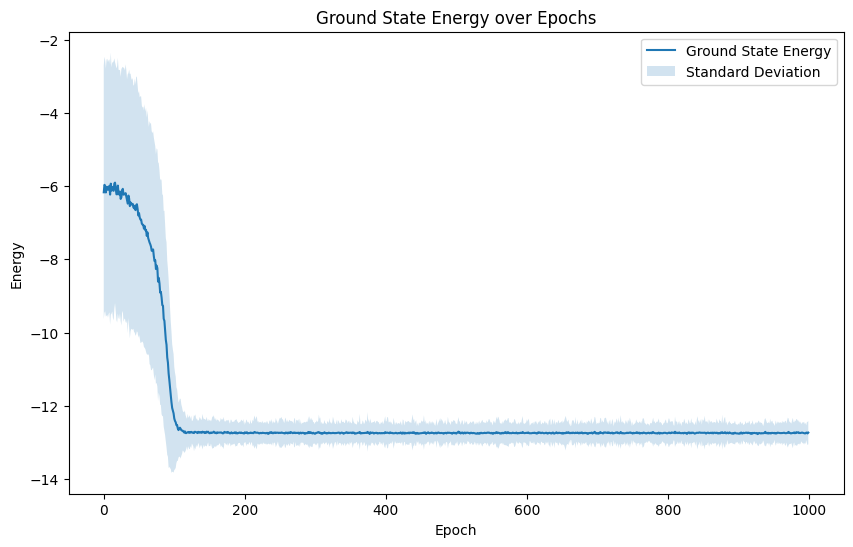

In [ ]:
import matplotlib.pyplot as plt

# Plot the ground state energy over epochs
epochs = range(len(learner.ground_energy))
energy = learner.ground_energy
energy_std = learner.ground_energy_std

plt.figure(figsize=(10, 6))
plt.plot(epochs, energy, label='Ground State Energy')
plt.fill_between(epochs,
                 [e - s for e, s in zip(energy, energy_std)],
                 [e + s for e, s in zip(energy, energy_std)],
                 alpha=0.2, label='Standard Deviation')
plt.xlabel('Epoch')
plt.ylabel('Energy')
plt.title('Ground State Energy over Epochs')
plt.legend()
plt.show()


## Visualize Magnetization

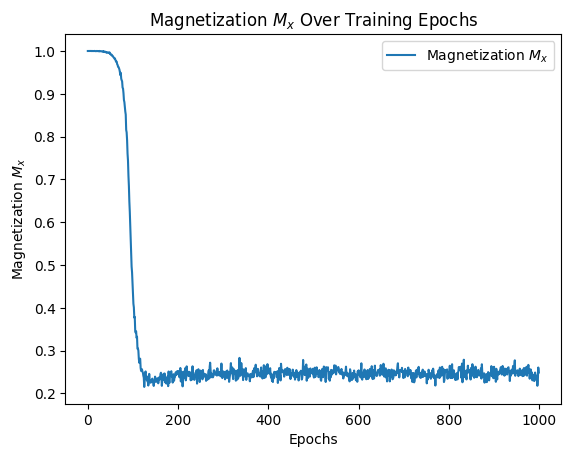

In [ ]:
learner.visualize_magnetization()


# Introduction to the Jastrow Wavefunction

**Some History** (skippable, but can be useful for future references): In 1955, physicist Robert Jastrow introduced the Jastrow wavefunction to improve upon existing variational methods for describing strongly interacting systems. He was primarily focused on nuclear and condensed matter physics, where particles (like electrons in metals or atoms in liquids) exhibit strong correlations that are difficult to capture with simple product-state or mean-field wavefunctions.

**Formulation**:

The Jastrow wavefunction is a variational ansatz used to represent the ground-state wavefunction in many-body quantum systems. It is written as:

$$
\Psi(S) = \prod_{i < j} f(r_{ij}),
$$

where $f(r_{ij})$ is a correlation function that depends on the distance $r_{ij}$ between particles $i$ and $j$. The specific form of $f$ is chosen to reflect the physical interactions in the system; for instance, it may decay with distance in systems where particles repel each other.


Recall that the Hamiltonian $H$ describing a system of $N$ interacting particles can be written as:

$$
H = -\frac{\hbar^2}{2m} \sum_{i=1}^N \nabla_{\vec{r}_i}^2 + \sum_{i} V_1 (\vec{r}_i) + \sum_{i < j} V_2 (\vec{r}_i, \vec{r}_j),
$$

where:

- $V_1 (\vec{r}_i)$ is a one-body potential affecting individual particles,
- $V_2 (\vec{r}_i, \vec{r}_j)$ is a two-body interaction potential describing the interaction between pairs of particles.


The Jastrow-Feenberg expansion expresses the many-body wavefunction $\psi_p (\vec{r}_1, \dots, \vec{r}_N)$ as following:

$$
\psi_p (\vec{r}_1, \dots, \vec{r}_N) = \psi_0 (\vec{r}_1, \dots, \vec{r}_N) \times \exp\left[ \sum_i J_1 (\vec{r}_i) + \frac{1}{2} \sum_{i \neq j} J_2 (\vec{r}_i, \vec{r}_j) + \dots + \frac{1}{p!} \sum_{i_1 \neq i_2 \neq \dots \neq i_p} J_p (\vec{r}_{i_1}, \vec{r}_{i_2}, \dots, \vec{r}_{i_p}) \right].
$$

Where,

- $\psi_0 (\vec{r}_1, \dots, \vec{r}_N)$ is a base wavefunction without any variational parameters
- $J_1 (\vec{r}_i)$, $J_2 (\vec{r}_i, \vec{r}_j)$, ..., $J_p (\vec{r}_{i_1}, \vec{r}_{i_2}, \dots, \vec{r}_{i_p})$ are the variational parameters. Each $J_n$ term captures correlations involving $n$ particles.

This expansion allows us to model the system’s wavefunction by incrementally incorporating correlations. The terms $J_1$ and $J_2$ typically capture most of the essential correlations for a wide range of systems. It is usually truncated at $p=2$ or $p=3$. The Jastrow wavefunction that we are going to be working with is the two-body wavefunction. It assumes the following form:

$$
C(\alpha, \vec{S}) = e^{-\alpha \sum_{i < j} \frac{\vec{S}_i \cdot \vec{S}_j}{|i - j|}}.
$$

Where $\alpha$ is the variational parameter chosen to minimize the expectation value of the Hamiltonian H with respect to the trial wavefunction. We use MCMC to minimize the wavefunction. Recall that we want to estimate ground-state energy $ E[\Psi] $ using the Jastrow wavefunction which is equivalent to

$
E[\Psi] = \frac{\langle \Psi | H | \Psi \rangle}{\langle \Psi | \Psi \rangle}
$. This expectation value is computed as a Monte Carlo integral:

$$
E[\Psi] = \int |\Psi(S)|^2 E_{\text{loc}}(S) \, dS
$$

where $ S $ is the configuration of particle states and $ E_{\text{loc}}(S) $ is the local energy, given by:

$
E_{\text{loc}}(S) = \frac{H \Psi(S)}{\Psi(S)}
$


To approximate this integral, we use Monte Carlo sampling, drawing samples $ S $ from the probability distribution $ |\Psi(S)|^2 $. The acceptance ratio assumes the form:
   $$
   A(S \to S') = \min\left(1, \frac{|\Psi(S')|^2}{|\Psi(S)|^2}\right)
   $$

Which looking at the structure of the wavefunction, is equal to:
$$
\Psi(S) = e^{-\alpha \sum_{i < j} \frac{\vec{S}_i \cdot \vec{S}_j}{|i - j|}}
$$

The Hamiltonian for which we are carrying out stochastic optimization is 1D spin chain with nearest-neighbor interactions given by:

$$
H = -J \sum_{i} s_i s_{i+1}
$$

# Stochastic Optimization of Jastrow Wavefunction

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
from flax import linen as nn
from jax import random
from typing import Any, Tuple
import time
from matplotlib import pyplot as plt

# Define the Ising Hamiltonian class with find_matrix_elements method
class Ising1D:
    def __init__(self, n_spins, h_x, periodic=True):
        self.n_spins = n_spins
        self.h_x = h_x
        self.periodic = periodic
        self.matrix_elements = np.zeros((n_spins + 1)) - self.h_x
        self.spin_flip_transitions = [[]] + [[i] for i in range(self.n_spins)]

    def find_matrix_elements(self, state):
        matrix_elements = self.matrix_elements
        matrix_elements[0] = 0.0

        # Compute Sz*Sz interaction part
        for i in range(self.n_spins - 1):
            matrix_elements[0] -= state[i] * state[i + 1]
        if self.periodic:
            matrix_elements[0] -= state[self.n_spins - 1] * state[0]

        return matrix_elements, self.spin_flip_transitions

# A Flax model subclassing `nn.Module`
class MF(nn.Module):
    @nn.compact
    def __call__(self, x):
        lam = self.param("lambda", nn.initializers.normal(), (1,), float)
        p = nn.log_sigmoid(lam * x)
        return 0.5 * jnp.sum(p, axis=-1)

class NQS:
    def __init__(self, model, params):
        self.model = model
        self.params = params

    def log_amplitude(self, state):
        return self.model.apply(self.params, state)

    def amplitude_ratio(self, state, flips):
        """Computes amplitude ratio given state and flip indices."""
        flipped_state = state.copy()
        for flip in flips:
            flipped_state[flip] *= -1
        log_amp_current = self.log_amplitude(state)
        log_amp_flipped = self.log_amplitude(flipped_state)
        return jnp.exp(log_amp_flipped - log_amp_current)

# Adapted local energy calculation function
def calculate_local_energy(state, hamiltonian, nqs):
    matrix_elements, transitions = hamiltonian.find_matrix_elements(state)
    energy_list = [nqs.amplitude_ratio(state, transitions[i]) * mel
                   for i, mel in enumerate(matrix_elements)]
    return sum(energy_list)

# Sample MCMC Sampler using the adapted local energy calculation
def mcmc_sampler(nqs, hamiltonian, interaction_strength, num_samples=5000, num_skip=3):
    spin_state = np.random.choice([-1, 1], size=hamiltonian.n_spins)
    energy_sum = 0.0

    for _ in range(num_samples):
        for _ in range(num_skip):
            spin_1 = np.random.randint(low=0, high=hamiltonian.n_spins)
            spin_2 = spin_1
            while spin_state[spin_2] * spin_state[spin_1] > 0:
                spin_2 = np.random.randint(low=0, high=hamiltonian.n_spins)

            proposed_spin_state = spin_state.copy()
            proposed_spin_state[spin_1] *= -1
            proposed_spin_state[spin_2] *= -1

            coeff_old = nqs.amplitude_ratio(spin_state, [])
            coeff_new = nqs.amplitude_ratio(proposed_spin_state, [])

            if np.random.random() < min(1.0, (coeff_new**2) / (coeff_old**2)):
                spin_state = proposed_spin_state.copy()

        local_energy = calculate_local_energy(spin_state, hamiltonian, nqs)
        energy_sum += local_energy

    return energy_sum / num_samples

# Initialize the model and parameters
key = random.PRNGKey(0)
num_spins = 12
model = MF()
params = model.init(key, jnp.ones((1, num_spins)))
nqs = NQS(model, params)

# Initialize Hamiltonian
hamiltonian = Ising1D(n_spins=num_spins, h_x=1.0, periodic=True)

# Run MCMC sampling
alpha_values = []
energy_estimates = []

start_time = time.time()

for alpha_step in range(-30, 40):
    alpha = alpha_step * 0.1
    estimated_energy = mcmc_sampler(nqs, hamiltonian, interaction_strength=alpha, num_samples=3000)
    alpha_values.append(alpha)
    energy_estimates.append(estimated_energy)
    print(f"Alpha: {alpha:.2f}, Energy Estimate: {estimated_energy:.6f}")

end_time = time.time()
print(f"Elapsed time: {end_time - start_time:.2f} sec")

# Plot the results
plt.xlabel("Interaction Strength (alpha)")
plt.ylabel("Estimated Energy")
plt.plot(alpha_values, energy_estimates, 'o', label="VMC")
plt.legend()
plt.show()


Alpha: -3.00, Energy Estimate: -11.274570
Alpha: -2.90, Energy Estimate: -16.852373


KeyboardInterrupt: 

## Defining the Jastrow ansatz (single parameter)

## Stochastic Optimization of the Jastrow Ansatz

We now optimize $E(\alpha)$. Note that for this, **we do not need to evaluate $\psi(S)$** for our aim is to estimate:

$$
\frac{\partial E(W)}{\partial \alpha_k} \approx \frac{1}{M} \sum_{m=1}^M \left( \frac{\partial E_{\text{loc}}(S^{(m)}; \alpha)}{\partial \alpha_k} + \left( E_{\text{loc}}(S^{(m)}; \alpha) - E(\alpha) \right) \frac{\partial \ln \psi(S^{(m)}; \alpha)}{\partial \alpha_k} \right)
$$

Firstly, lets estimate the log-derivative of the wave-function. The logarithmic derivative of $ \Psi(S) $ with respect to $ \alpha $ is given by: $
\frac{\partial \ln \Psi(S)}{\partial \alpha} = \frac{1}{\Psi(S)} \frac{\partial \Psi(S)}{\partial \alpha} $. From the form of the Jatrow wavefunction, we obtain:
.
$$
\ln \Psi(S) = -\alpha \sum_{i < j} \frac{S_i S_j}{\text{distance}_{ij}}
$$

Thus the derivative is:

$$
\frac{\partial \ln \Psi(S)}{\partial \alpha} = -\sum_{i < j} \frac{S_i S_j}{\text{distance}_{ij}}
$$






In [ ]:
import numpy as np
import math
import numba
import time
from matplotlib import pyplot as plt

@numba.jit(nopython=True)
def calculate_log_derivative(spin_configuration, interaction_strength, num_sites):

    log_derivative_sum = 0.0
    for site_a in range(num_sites):
        for site_b in range(site_a + 1, num_sites):
            # Calculate the shortest distance between spins, with periodic boundary conditions
            shortest_distance = min(abs(site_b - site_a), num_sites - abs(site_b - site_a))
            # Add the contribution of spin pair (site_a, site_b) to the log-derivative
            log_derivative_sum += spin_configuration[site_a] * spin_configuration[site_b] / shortest_distance
    return log_derivative_sum

@numba.jit(nopython=True)
def compute_wavefunction_value(spin_configuration, interaction_strength, num_sites):

    # Calculate the sum of spin correlations weighted by distance
    correlation_sum = calculate_log_derivative(spin_configuration, interaction_strength, num_sites)

    # Compute the Jastrow wavefunction value Ψ(S)
    wavefunction_value = math.exp(-interaction_strength * correlation_sum)

    return wavefunction_value

@numba.jit(nopython=True)
def calculate_local_energy(spin_configuration, wavefunction_coefficient, interaction_strength, num_sites):
    """
    Given a state Ψ(s_i), this calculates the local energy E_loc(s_i) which is essentially the value of
    Hamiltonian for a given spin configuration.

    """
    print(spin_configuration)
    interaction_energy = 0.0
    for site in range(num_sites):
        interaction_energy += spin_configuration[site] * spin_configuration[(site + 1) % num_sites]

    spin_flip_contributions = 0.0
    for site in range(num_sites):
        if spin_configuration[site] * spin_configuration[(site + 1) % num_sites] < 0.0:
            flipped_configuration = spin_configuration.copy()
            flipped_configuration[site] *= -1.0
            flipped_configuration[(site + 1) % num_sites] *= -1.0
            spin_flip_contributions += compute_wavefunction_value(flipped_configuration, interaction_strength, num_sites) / wavefunction_coefficient

    E_loc = interaction_energy - 0.5 * spin_flip_contributions
    print(E_loc)
    return E_loc



## Metropolis Sampling for Stochastic Optimization

We will now carry out metropolis sampling. This time, rather than using MCMC to estimate $\psi(\alpha)$ as we did above, we would be estimating the following quantity of interest:

$$
\frac{\partial E(\alpha)}{\partial \alpha} \approx \frac{1}{M} \sum_{m=1}^M \left( \frac{\partial E_{\text{loc}}(S^{(m)}; \alpha)}{\partial \alpha} + \left( E_{\text{loc}}(S^{(m)}; \alpha) - E(\alpha) \right) \frac{\partial \ln \Psi(S^{(m)}; \alpha)}{\partial \alpha} \right)
$$

The above can be seen as consisting of three main quantities:

1. **Average of Local Energy**:
  $
  \frac{1}{M} \sum_{m=1}^M E_{\text{loc}}(S^{(m)}; \alpha)
  $

2. **Average of Log-Derivative**:
  $
  \frac{1}{M} \sum_{m=1}^M \frac{\partial \ln \Psi(S^{(m)}; \alpha)}{\partial \alpha}
  $
3. **Product of Local Energy and Log-Derivative**: $
  \frac{1}{M} \sum_{m=1}^M E_{\text{loc}}(S^{(m)}; \alpha) \cdot \frac{\partial \ln \Psi(S^{(m)}; \alpha)}{\partial \alpha}  $


For Local Energy, for a given configuration $ S^{(m)} $, the local energy is defined as: $ E_{\text{loc}}(S^{(m)}; \alpha) = \frac{H \Psi(S^{(m)})}{\Psi(S^{(m)})} $ Our function `calculate_local_energy` computes this and we will accumulates the sum of these local energy values over all samples to get an average. Thus, our metropolis hasting would return:
1. **Average of Local Energy**:
2. **Average of Logarithmic Derivative**:
3. **Average of Product of Local Energy and Logarithmic Derivative**:


In [ ]:
@numba.jit(nopython=True)
def metropolis_sampling(interaction_strength, num_sites, num_samples=2000, num_skips=3):
    """
    Perform the Metropolis-Hastings algorithm to estimate the gradient and energy.

    Parameters:
    - interaction_strength: The parameter alpha.
    - num_sites: Number of sites (or particles).
    - num_samples: Number of samples to generate.
    - num_skips: Number of steps to skip between samples.

    Returns:
    - A tuple containing the averages for HO_sum, log_derivative_sum, and energy_sum.
    """
    spin_configuration = np.ones(num_sites)
    spin_configuration[:num_sites // 2] = -1
    spin_configuration *= 0.5
    spin_configuration = spin_configuration[np.random.permutation(num_sites)]

    energy_total = 0.0
    log_derivative_total = 0.0
    HO_total = 0.0

    for _ in range(num_samples):
        # Propose new state by flipping spins
        for _ in range(num_skips):
            spin_a = np.random.randint(low=0, high=num_sites)
            spin_b = spin_a
            while spin_configuration[spin_b] * spin_configuration[spin_a] > 0:
                spin_b = np.random.randint(low=0, high=num_sites)

            proposed_configuration = spin_configuration.copy()
            proposed_configuration[spin_a] *= -1.0
            proposed_configuration[spin_b] *= -1.0

            coeff_old = compute_wavefunction_value(spin_configuration, interaction_strength, num_sites)
            coeff_new = compute_wavefunction_value(proposed_configuration, interaction_strength, num_sites)

            # Metropolis acceptance criterion
            if np.random.random() < min(1.0, (coeff_new**2) / (coeff_old**2)):
                spin_configuration = proposed_configuration.copy()
                coeff_old = coeff_new

        # Compute local energy, log derivative, and the HO term
        current_energy = calculate_local_energy(spin_configuration, coeff_old, interaction_strength, num_sites)
        current_log_derivative = -1.0 * calculate_log_derivative(spin_configuration, interaction_strength, num_sites)
        HO_contribution = current_energy * current_log_derivative

        energy_total += current_energy
        log_derivative_total += current_log_derivative
        HO_total += HO_contribution

    return HO_total / num_samples, log_derivative_total / num_samples, energy_total / num_samples



Elapsed time: 3.11 sec


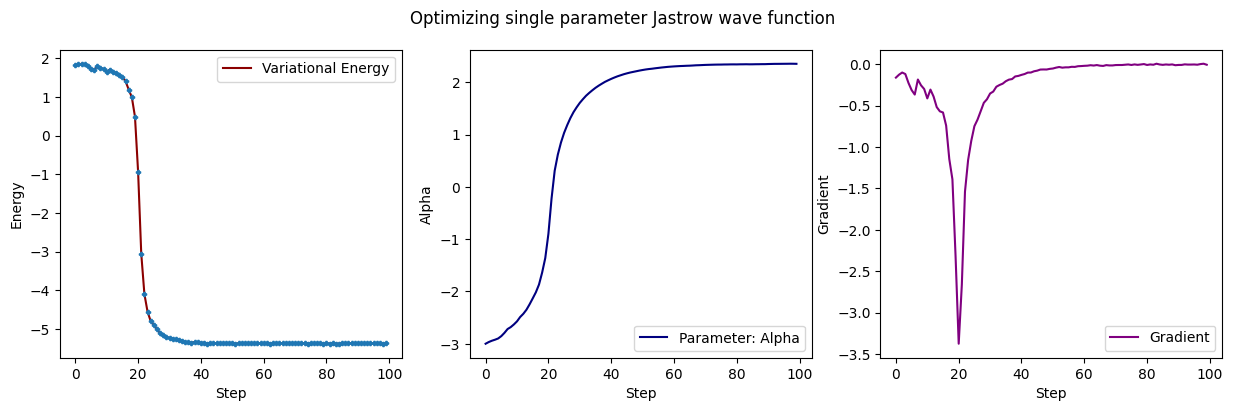

In [ ]:
def optimize_parameter(interaction_strength, num_sites, num_samples, learning_rate):
    """
    Perform gradient descent to optimize interaction strength (alpha) for the Jastrow wavefunction.

    Parameters:
    - interaction_strength: Initial value of alpha.
    - num_sites: Number of sites (or particles).
    - num_samples: Number of samples per iteration.
    - learning_rate: Step size for updating alpha.
    """
    alpha_values = []
    steps = []
    energies = []
    gradients = []

    start_time = time.time()
    for step in range(100):
        HO_total, log_derivative_total, average_energy = metropolis_sampling(interaction_strength, num_sites, num_samples)

        # Calculate the gradient of E(alpha) with respect to alpha
        gradient = 2 * HO_total - 2 * log_derivative_total * average_energy

        # Append data for plotting
        alpha_values.append(interaction_strength)
        steps.append(step)
        gradients.append(gradient)
        energies.append(average_energy)

        # Update alpha with gradient descent
        interaction_strength -= learning_rate * gradient

    end_time = time.time()
    print("Elapsed time: %.2f sec" % (end_time - start_time))

    # Plot the results
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
    ax1.plot(steps, energies, color="darkred", label="Variational Energy")
    ax1.plot(steps, energies, "P", markersize=3)
    ax2.plot(steps, alpha_values, color="navy", label="Parameter: Alpha")
    ax3.plot(steps, gradients, color="purple", label="Gradient")

    ax1.set(xlabel="Step", ylabel="Energy")
    ax2.set(xlabel="Step", ylabel="Alpha")
    ax3.set(xlabel="Step", ylabel="Gradient")

    ax1.legend()
    ax2.legend()
    ax3.legend()

    plt.suptitle("Optimizing single parameter Jastrow wave function")
    plt.show()

if __name__ == '__main__':
    num_sites = 12
    num_samples = 5000
    learning_rate = 0.2
    initial_alpha = -3.0

    optimize_parameter(initial_alpha, num_sites, num_samples, learning_rate)

## Jastrow Wavefunction (multiple parameters)

In the previous example, we only had a single parameter $\alpha$ to optimize. In this case, we would be optimizing the more general wavefunction:

$$
J(\alpha_{ij}, \vec{s}) = e^{-\sum_{ij} \alpha_{ij} S_i^z S_j^z}
$$

Where now the number of variables are $N^2$ for $N$ number of particles.

Exception ignored on calling ctypes callback function: <function ExecutionEngine._raw_object_cache_notify at 0x7dfdf0b3bd90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/llvmlite/binding/executionengine.py", line 178, in _raw_object_cache_notify
    def _raw_object_cache_notify(self, data):
KeyboardInterrupt: 


Step 0, energy -4.8629
Step 1, energy -5.3951
Step 2, energy -6.0807
Step 3, energy -6.5493
Step 4, energy -7.3170
Step 5, energy -7.7034
Step 6, energy -8.1773
Step 7, energy -8.4558
Step 8, energy -8.8812
Step 9, energy -9.1591
Step 10, energy -9.2477
Step 11, energy -9.4285
Step 12, energy -9.5896
Step 13, energy -9.6996
Step 14, energy -9.7879
Step 15, energy -9.8645
Step 16, energy -9.9303
Step 17, energy -9.9566
Step 18, energy -9.9955
Step 19, energy -10.0603
Step 20, energy -10.0983
Step 21, energy -10.1625
Step 22, energy -10.1971
Step 23, energy -10.1866
Step 24, energy -10.2184
Step 25, energy -10.2814
Step 26, energy -10.2878
Step 27, energy -10.3019
Step 28, energy -10.3143
Step 29, energy -10.3011
Step 30, energy -10.3449
Step 31, energy -10.3944
Step 32, energy -10.3697
Step 33, energy -10.3707
Step 34, energy -10.3695
Step 35, energy -10.4208
Step 36, energy -10.4026
Step 37, energy -10.4273
Step 38, energy -10.4079
Step 39, energy -10.4383
Step 40, energy -10.4535
Step

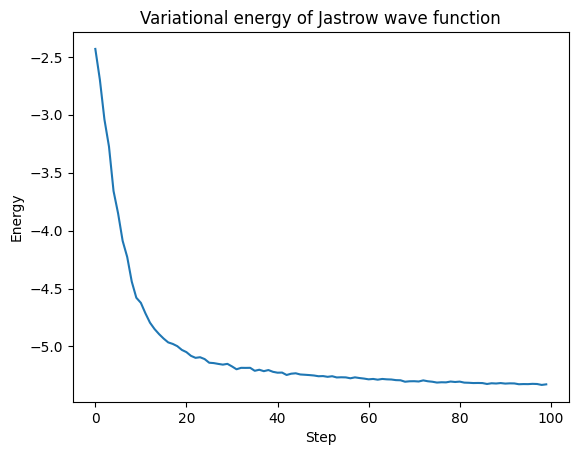

In [ ]:
import numpy as np
import cmath
import numba
import time
from matplotlib import pyplot as plt

@numba.jit
def compute_log_derivative(spin_configuration, interaction_matrix, num_sites):

    log_derivative_matrix = np.zeros((num_sites, num_sites))
    log_derivative_matrix = np.outer(spin_configuration, spin_configuration) * -1.0

    return log_derivative_matrix

@numba.jit
def compute_wavefunction_value(spin_configuration, interaction_matrix, num_sites):

    interaction_sum = np.sum(np.multiply(interaction_matrix, np.outer(spin_configuration, spin_configuration)))
    return cmath.exp(-interaction_sum)

@numba.jit
def calculate_local_energy(spin_configuration, wavefunction_coeff, interaction_matrix, num_sites):

    nearest_neighbor_interaction = 0.0

    for site in range(num_sites):
        nearest_neighbor_interaction += spin_configuration[site] * spin_configuration[(site + 1) % num_sites]

    spin_flip_contributions = 0.0

    for site in range(num_sites):
        if spin_configuration[site] * spin_configuration[(site + 1) % num_sites] < 0.0:
            flipped_configuration = spin_configuration.copy()
            flipped_configuration[site] *= -1.0
            flipped_configuration[(site + 1) % num_sites] *= -1.0
            spin_flip_contributions += compute_wavefunction_value(flipped_configuration, interaction_matrix, num_sites) / wavefunction_coeff

    return nearest_neighbor_interaction - 0.5 * spin_flip_contributions

@numba.jit
def metropolis_sampling(interaction_matrix, num_sites, num_samples=2000, num_skips=3):

    spin_configuration = np.ones(num_sites)
    spin_configuration[: num_sites // 2] = -1
    spin_configuration *= 0.5
    spin_configuration = spin_configuration[np.random.permutation(num_sites)]

    energy_sum = 0.0
    log_derivative_sum = np.zeros((num_sites, num_sites), dtype=np.cdouble)
    energy_gradient_product_sum = np.zeros((num_sites, num_sites), dtype=np.cdouble)

    for _ in range(num_samples):
        # Propose new state by flipping spins
        for _ in range(num_skips):
            spin_a = np.random.randint(low=0, high=num_sites)
            spin_b = spin_a
            while spin_configuration[spin_b] * spin_configuration[spin_a] > 0:
                spin_b = np.random.randint(low=0, high=num_sites)

            proposed_configuration = spin_configuration.copy()
            proposed_configuration[spin_a] *= -1.0
            proposed_configuration[spin_b] *= -1.0

            current_wavefunction = compute_wavefunction_value(spin_configuration, interaction_matrix, num_sites)
            proposed_wavefunction = compute_wavefunction_value(proposed_configuration, interaction_matrix, num_sites)

            # Metropolis acceptance criterion
            if np.random.random() < min(1.0, np.abs(proposed_wavefunction / current_wavefunction)):
                spin_configuration = proposed_configuration.copy()
                current_wavefunction = proposed_wavefunction

        # Compute local energy, log derivative, and energy-gradient product
        current_energy = calculate_local_energy(spin_configuration, current_wavefunction, interaction_matrix, num_sites)
        current_log_derivative = compute_log_derivative(spin_configuration, interaction_matrix, num_sites)

        energy_sum += current_energy
        log_derivative_sum += np.conjugate(current_log_derivative)
        energy_gradient_product_sum += np.conjugate(current_log_derivative) * current_energy

    return energy_gradient_product_sum / num_samples, log_derivative_sum / num_samples, energy_sum / num_samples

def optimize_parameters(interaction_matrix, num_sites, num_samples, learning_rate):

    steps = []
    energies = []
    start_time = time.time()

    with open("energy_jastrow_matrix.txt", "w") as fp:
        for step in range(100):
            ho_sum, log_derivative_sum, average_energy = metropolis_sampling(interaction_matrix, num_sites, num_samples)
            gradient = 2 * ho_sum - 2 * log_derivative_sum * average_energy

            print(f"Step {step}, energy {average_energy.real:.4f}")
            fp.write(f"{step}  {average_energy.real:.4f}\n")

            steps.append(step)
            energies.append(average_energy.real)
            interaction_matrix -= learning_rate * gradient

    end_time = time.time()
    print("Elapsed time: %.2f sec" % (end_time - start_time))

    plt.plot(steps, energies)
    plt.xlabel("Step")
    plt.ylabel("Energy")
    plt.title("Variational energy of Jastrow wave function")
    plt.show()

if __name__ == '__main__':
    num_sites = 12
    num_samples = 5000
    learning_rate = 0.2
    real_part = np.random.random((num_sites, num_sites))
    imag_part = np.random.random((num_sites, num_sites))
    initial_interaction_matrix = real_part + 1j * imag_part

    optimize_parameters(initial_interaction_matrix, num_sites, num_samples, learning_rate)


# RBM-Ansatz

Let us now work with the RBM-ansatz that the authors of the paper, "Solving the Quantum Many-Body Problem with Artificial Neural Networks"* utilized:

$$
\psi(\vec{s}, a, b, W) = e^{\sum_{i=1}^{N} a_i s_i} \prod_{i=1}^{M} \left[ 2 \cosh \left( \sum_{j=1}^{N} W_{ij} s_j + b_i \right) \right]
$$

Where N is the number of **visible layers** and M is the number of **hidden layers**. The authors state that as M increases, the RBM wavefunction can better approximate the true quantum wavefunction. In the limit of $ M → ∞ $, an RBM can theoretically represent any arbitrary function, meaning that it can capture the entire Hilbert space of possible wavefunctions.

Once again, our aim is to perform the following stochastic optimization:

$$
\frac{\partial E(\alpha)}{\partial \alpha} \approx \frac{1}{M} \sum_{m=1}^M \left( \frac{\partial E_{\text{loc}}(S^{(m)}; \alpha)}{\partial \alpha} + \left( E_{\text{loc}}(S^{(m)}; \alpha) - E(\alpha) \right) \frac{\partial \ln \Psi(S^{(m)}; \alpha)}{\partial \alpha} \right)
$$


However in this case, we now have the parameters $a$, $b$ and $W$ that we would optimize. The logarithm of the wavefunction $ \psi(\vec{s}, a, b, W) $ is given by:

$$
\ln \psi(\vec{s}, a, b, W) = \sum_{i=1}^{M} a_i s_i + \sum_{i=1}^{M} \ln \left[ 2 \cosh \left( \sum_{j=1}^{N} W_{ij} s_j + b_i \right) \right]
$$

The derivatives then become:


   $$
   \frac{\partial \ln \psi(\vec{s}, a, b, W)}{\partial a_i} = s_i
   $$

The derivative of cosh is sinh. Keeping this in mind, we have:


   $$
   \frac{\partial \ln \psi(\vec{s}, a, b, W)}{\partial b_j} = \tanh \left( \sum_{k=1}^{N} W_{jk} s_k + b_j \right)
   $$

Finally, the partial Derivative with Respect to \( W_{ij} \) is:


   $$
   \frac{\partial \ln \psi(\vec{s}, a, b, W)}{\partial W_{ij}} = s_i \tanh \left( \sum_{k=1}^{N} W_{jk} s_k + b_j \right)
   $$

Thus,

- For $ a_i $:
  $
  \frac{\partial \ln \psi(\vec{s}, a, b, W)}{\partial a_i} = s_i
  $

- For $ b_j $:
  $
  \frac{\partial \ln \psi(\vec{s}, a, b, W)}{\partial b_j} = \tanh \left( \sum_{k=1}^{N} W_{jk} s_k + b_j \right)
  $

- For $ W_{ij} $:
  $
  \frac{\partial \ln \psi(\vec{s}, a, b, W)}{\partial W_{ij}} = s_i \tanh \left( \sum_{k=1}^{N} W_{jk} s_k + b_j \right)
  $



Step 0, energy -5.2568
Step 1, energy -6.9847
Step 2, energy -7.6547
Step 3, energy -7.9528
Step 4, energy -8.1691
Step 5, energy -8.4176
Step 6, energy -8.5347
Step 7, energy -8.8125
Step 8, energy -8.9352
Step 9, energy -9.0926
Step 10, energy -9.2043
Step 11, energy -9.3433
Step 12, energy -9.4337
Step 13, energy -9.4624
Step 14, energy -9.5532
Step 15, energy -9.6170
Step 16, energy -9.6292
Step 17, energy -9.7072
Step 18, energy -9.7597
Step 19, energy -9.7714
Step 20, energy -9.8233
Step 21, energy -9.8880
Step 22, energy -9.9604
Step 23, energy -9.9600
Step 24, energy -9.9809
Step 25, energy -10.0105
Step 26, energy -10.0455
Step 27, energy -10.0110
Step 28, energy -10.0831
Step 29, energy -10.0789
Step 30, energy -10.1045
Step 31, energy -10.1420
Step 32, energy -10.1360
Step 33, energy -10.1888
Step 34, energy -10.1479
Step 35, energy -10.1723
Step 36, energy -10.1777
Step 37, energy -10.1942
Step 38, energy -10.2220
Step 39, energy -10.2613
Step 40, energy -10.2158
Step 41, e

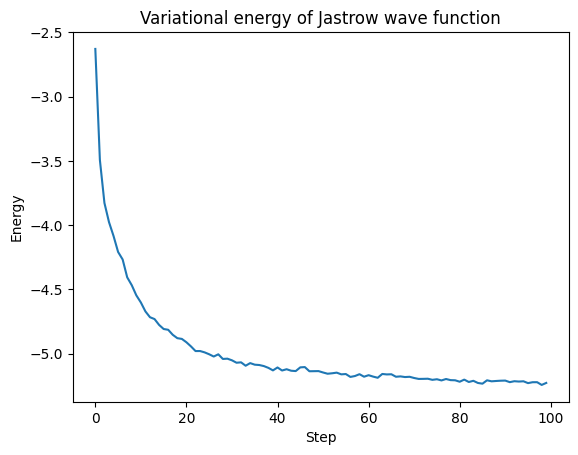

In [ ]:
import numpy as np
import cmath
import numba
import time
from matplotlib import pyplot as plt

@numba.jit
def compute_log_derivative(spin_config, weight_matrix, num_sites):
    """
    Compute the log-derivative matrix of the wavefunction with respect to the weight matrix.
    """
    log_derivative_matrix = np.zeros((num_sites, num_sites), dtype=np.cdouble)
    activation_vector = np.zeros(num_sites, dtype=np.cdouble)

    # Compute the activations for each site
    for site_idx in range(num_sites):
        weighted_sum = 0.0
        for neighbor_idx in range(num_sites):
            weighted_sum += weight_matrix[site_idx][neighbor_idx] * spin_config[neighbor_idx]
        activation_vector[site_idx] = weighted_sum

    # Compute the log-derivative matrix
    log_derivative_matrix = np.outer(np.tanh(activation_vector), spin_config)

    return log_derivative_matrix

@numba.jit
def compute_wavefunction_value(spin_config, weight_matrix, num_sites):
    """
    Compute the value of the wavefunction for a given spin configuration.
    """
    activation_vector = np.zeros(num_sites, dtype=np.cdouble)

    # Calculate the product of cosh(activation) for each site
    for site_idx in range(num_sites):
        weighted_sum = 0.0
        for neighbor_idx in range(num_sites):
            weighted_sum += weight_matrix[site_idx][neighbor_idx] * spin_config[neighbor_idx]
        activation_vector[site_idx] = weighted_sum

    # Compute the wavefunction value
    return np.prod(np.cosh(activation_vector))

@numba.jit
def compute_local_energy(spin_config, wavefunction_coeff, weight_matrix, num_sites):
    """
    Compute the local energy for a given spin configuration.
    """
    interaction_energy = 0.0
    for i in range(num_sites):
        interaction_energy += spin_config[i] * spin_config[(i + 1) % num_sites]

    flip_energy_sum = 0.0
    for i in range(num_sites):
        if spin_config[i] * spin_config[(i + 1) % num_sites] < 0.0:
            flipped_state = spin_config.copy()
            flipped_state[i] *= -1.0
            flipped_state[(i + 1) % num_sites] *= -1.0
            flip_energy_sum += compute_wavefunction_value(flipped_state, weight_matrix, num_sites) / wavefunction_coeff

    return interaction_energy - 0.5 * flip_energy_sum

@numba.jit
def metropolis_sampling(weight_matrix, num_sites, num_samples=2000, num_skips=3):

    spin_configuration = np.ones(num_sites)
    spin_configuration[: num_sites // 2] = -1
    spin_configuration *= 0.5
    spin_configuration = spin_configuration[np.random.permutation(num_sites)]

    energy_sum = 0.0
    log_derivative_sum = np.zeros((num_sites, num_sites), dtype=np.cdouble)
    energy_gradient_product_sum = np.zeros((num_sites, num_sites), dtype=np.cdouble)

    for _ in range(num_samples):
        # Propose new state by flipping spins
        for _ in range(num_skips):
            spin_a = np.random.randint(low=0, high=num_sites)
            spin_b = spin_a
            while spin_configuration[spin_b] * spin_configuration[spin_a] > 0:
                spin_b = np.random.randint(low=0, high=num_sites)

            proposed_configuration = spin_configuration.copy()
            proposed_configuration[spin_a] *= -1.0
            proposed_configuration[spin_b] *= -1.0

            current_wavefunction = compute_wavefunction_value(spin_configuration, weight_matrix, num_sites)
            proposed_wavefunction = compute_wavefunction_value(proposed_configuration, weight_matrix, num_sites)

            # Metropolis acceptance criterion
            if np.random.random() < min(1.0, np.abs(proposed_wavefunction / current_wavefunction)):
                spin_configuration = proposed_configuration.copy()
                current_wavefunction = proposed_wavefunction

        # Compute local energy, log derivative, and energy-gradient product
        current_energy = compute_local_energy(spin_configuration, current_wavefunction, weight_matrix, num_sites)
        current_log_derivative = compute_log_derivative(spin_configuration, weight_matrix, num_sites)

        energy_sum += current_energy
        log_derivative_sum += np.conjugate(current_log_derivative)
        energy_gradient_product_sum += np.conjugate(current_log_derivative) * current_energy

    return energy_gradient_product_sum / num_samples, log_derivative_sum / num_samples, energy_sum / num_samples

def optimize_parameters(weight_matrix, num_sites, num_samples, learning_rate):

    steps = []
    energies = []
    start_time = time.time()

    with open("energy_jastrow_matrix.txt", "w") as fp:
        for step in range(100):
            ho_sum, log_derivative_sum, average_energy = metropolis_sampling(weight_matrix, num_sites, num_samples)
            gradient = 2 * ho_sum - 2 * log_derivative_sum * average_energy

            print(f"Step {step}, energy {average_energy.real:.4f}")
            fp.write(f"{step}  {average_energy.real:.4f}\n")

            steps.append(step)
            energies.append(average_energy.real)
            weight_matrix -= learning_rate * gradient

    end_time = time.time()
    print("Elapsed time: %.2f sec" % (end_time - start_time))

    plt.plot(steps, energies)
    plt.xlabel("Step")
    plt.ylabel("Energy")
    plt.title("Variational energy of Jastrow wave function")
    plt.show()

if __name__ == '__main__':
    num_sites = 12
    num_samples = 5000
    learning_rate = 0.2
    real_part = np.random.random((num_sites, num_sites))
    imag_part = np.random.random((num_sites, num_sites))
    initial_interaction_matrix = real_part + 1j * imag_part

    optimize_parameters(initial_interaction_matrix, num_sites, num_samples, learning_rate)



## Optimizing the RBM-Ansatz using the Fubinic Norm



The Fubini-Study norm is used in quantum mechanics to measure the "distance" or dissimilarity between quantum states. Using the Fubini-Study norm introduces a form of natural gradient descent that respects the geometry of the quantum state space.

In standard gradient descent,  we minimized the cost function $ E(\theta) = \langle \Psi(\theta) | H | \Psi(\theta) \rangle $ through stochastic gradient descent.

$$
\theta_{t+1} = \theta_t - \eta \nabla_\theta E(\theta)
$$

where $ \eta $ is the learning rate. This approach does not account for the underlying geometry of the parameter space.

The Fubini-Study metric provides a way to measure distances in quantum state space. It respects the curved geometry of the wavefunction manifold. In neural-network quantum states (NQS), the Fubini-Study metric leads to a "natural gradient" descent that is more effective for navigating parameter space than standard gradient descent.


For two nearby states $ |\Psi(\theta)\rangle $ and $ |\Psi(\theta + d\theta)\rangle $, the Fubini-Study distance $ ds $ between them is given by:

$$
ds^2 = 1 - |\langle \Psi(\theta) | \Psi(\theta + d\theta) \rangle|^2
$$

For infinitesimal parameter changes $ d\theta $, this distance becomes:

$$
ds^2 \approx \langle \partial_\theta \Psi | \partial_\theta \Psi \rangle - |\langle \Psi | \partial_\theta \Psi \rangle|^2 = g_{ij} \, d\theta^i d\theta^j
$$

where $ g_{ij} $ is the quantum geometric tensor (QGT), acting as the metric in parameter space. This tensor captures how changes in parameters impact the wavefunction.


Using the Fubini-Study metric, the natural gradient step is given by:

$$
\delta \theta = - \eta \, g^{-1} \nabla_\theta E(\theta)
$$

where $ g $ is the QGT which accumulates outer products of log-derivative terms.


This natural gradient accounts for the curvature of the parameter space, adjusting the step size in each direction to follow the underlying geometry more closely.



Step 0, Energy: -2.0998
Step 1, Energy: -2.7454
Step 2, Energy: -3.1221
Step 3, Energy: -3.3812
Step 4, Energy: -3.5166
Step 5, Energy: -3.5806
Step 6, Energy: -3.6176
Step 7, Energy: -3.6309
Step 8, Energy: -3.6397
Step 9, Energy: -3.6445
Step 10, Energy: -3.6472
Step 11, Energy: -3.6486
Step 12, Energy: -3.6496
Step 13, Energy: -3.6501
Step 14, Energy: -3.6505
Step 15, Energy: -3.6507
Step 16, Energy: -3.6509
Step 17, Energy: -3.6509
Step 18, Energy: -3.6510
Step 19, Energy: -3.6510
Step 20, Energy: -3.6511
Step 21, Energy: -3.6511
Step 22, Energy: -3.6511
Step 23, Energy: -3.6511
Step 24, Energy: -3.6511
Step 25, Energy: -3.6511
Step 26, Energy: -3.6511
Step 27, Energy: -3.6511
Step 28, Energy: -3.6511
Step 29, Energy: -3.6511
Step 30, Energy: -3.6511
Step 31, Energy: -3.6511
Step 32, Energy: -3.6511
Step 33, Energy: -3.6511
Step 34, Energy: -3.6511
Step 35, Energy: -3.6511
Step 36, Energy: -3.6511
Step 37, Energy: -3.6511
Step 38, Energy: -3.6511
Step 39, Energy: -3.6511
Step 40, E

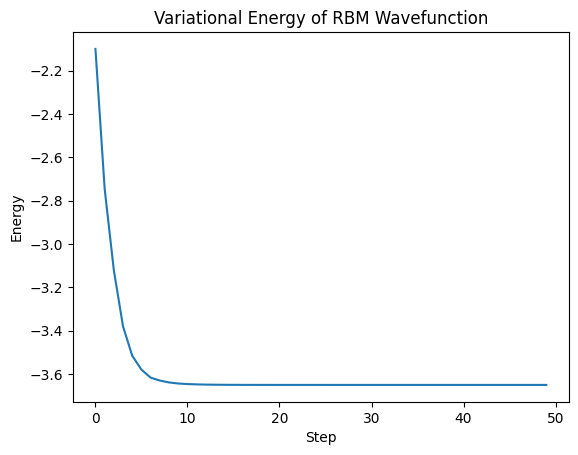

In [ ]:
import numpy as np
import cmath
import numba
import time
from matplotlib import pyplot as plt

@numba.jit
def compute_log_derivative(spin_config, weight_matrix, num_sites):
    """
    Compute the log-derivative matrix of the wavefunction with respect to the weight matrix.
    """
    log_derivative_matrix = np.zeros((num_sites, num_sites), dtype=np.cdouble)
    activation_vector = np.zeros(num_sites, dtype=np.cdouble)

    # Compute the activations for each site
    for site_idx in range(num_sites):
        weighted_sum = 0.0
        for neighbor_idx in range(num_sites):
            weighted_sum += weight_matrix[site_idx][neighbor_idx] * spin_config[neighbor_idx]
        activation_vector[site_idx] = weighted_sum

    # Compute the log-derivative matrix
    log_derivative_matrix = np.outer(np.tanh(activation_vector), spin_config)

    return log_derivative_matrix

@numba.jit
def compute_wavefunction_value(spin_config, weight_matrix, num_sites):
    """
    Compute the value of the wavefunction for a given spin configuration.
    """
    activation_vector = np.zeros(num_sites, dtype=np.cdouble)

    # Calculate the product of cosh(activation) for each site
    for site_idx in range(num_sites):
        weighted_sum = 0.0
        for neighbor_idx in range(num_sites):
            weighted_sum += weight_matrix[site_idx][neighbor_idx] * spin_config[neighbor_idx]
        activation_vector[site_idx] = weighted_sum

    # Compute the wavefunction value
    return np.prod(np.cosh(activation_vector))

@numba.jit
def compute_local_energy(spin_config, wavefunction_coeff, weight_matrix, num_sites):
    """
    Compute the local energy for a given spin configuration.
    """
    interaction_energy = 0.0
    for i in range(num_sites):
        interaction_energy += spin_config[i] * spin_config[(i + 1) % num_sites]

    flip_energy_sum = 0.0
    for i in range(num_sites):
        if spin_config[i] * spin_config[(i + 1) % num_sites] < 0.0:
            flipped_state = spin_config.copy()
            flipped_state[i] *= -1.0
            flipped_state[(i + 1) % num_sites] *= -1.0
            flip_energy_sum += compute_wavefunction_value(flipped_state, weight_matrix, num_sites) / wavefunction_coeff

    return interaction_energy - 0.5 * flip_energy_sum

@numba.jit
def metropolis_sampling(weight_matrix, num_sites, num_samples=2000, num_skips=3):
    """
    Perform Metropolis-Hastings sampling to estimate the gradient and energy.
    """
    spin_config = np.ones(num_sites)
    spin_config[:num_sites // 2] = -1
    spin_config *= 0.5
    spin_config = spin_config[np.random.permutation(num_sites)]

    total_energy = 0.0
    log_derivative_total = np.zeros((num_sites, num_sites), dtype=np.cdouble)
    energy_logderiv_sum = np.zeros((num_sites, num_sites), dtype=np.cdouble)

    flattened_log_deriv_sum = np.zeros(num_sites * num_sites, dtype=np.cdouble)
    outer_log_deriv_sum = np.zeros((num_sites * num_sites, num_sites * num_sites), dtype=np.cdouble)

    for sample in range(num_samples):
        # Perform spin flips for the given number of steps
        for step in range(num_skips):
            site_a = np.random.randint(low=0, high=num_sites)
            site_b = site_a
            while spin_config[site_b] * spin_config[site_a] > 0:
                site_b = np.random.randint(low=0, high=num_sites)

            proposed_config = spin_config.copy()
            proposed_config[site_a] *= -1.0
            proposed_config[site_b] *= -1.0

            coeff_old = compute_wavefunction_value(spin_config, weight_matrix, num_sites)
            coeff_new = compute_wavefunction_value(proposed_config, weight_matrix, num_sites)

            # Metropolis acceptance criterion
            if np.random.random() < min(1.0, np.abs(coeff_new / coeff_old)):
                spin_config = proposed_config.copy()
                coeff_old = coeff_new

        # Compute local energy and log-derivative
        local_energy_value = compute_local_energy(spin_config, coeff_old, weight_matrix, num_sites)
        log_derivative_value = compute_log_derivative(spin_config, weight_matrix, num_sites)

        # Accumulate values for natural gradient descent
        flattened_log_deriv_sum += log_derivative_value.flatten()
        outer_log_deriv_sum += np.outer(np.conjugate(log_derivative_value.flatten()), log_derivative_value.flatten())

        log_derivative_value = np.conjugate(log_derivative_value)

        total_energy += local_energy_value
        log_derivative_total += log_derivative_value
        energy_logderiv_sum += log_derivative_value * local_energy_value

    # Normalize accumulated values
    total_energy /= num_samples
    log_derivative_total /= num_samples
    energy_logderiv_sum /= num_samples
    flattened_log_deriv_sum /= num_samples
    outer_log_deriv_sum /= num_samples

    # Adjust outer product for natural gradient
    outer_log_deriv_sum -= np.outer(np.conjugate(flattened_log_deriv_sum), flattened_log_deriv_sum)

    # Compute the natural gradient
    gradient = energy_logderiv_sum - log_derivative_total * total_energy
    gradient_vector = gradient.flatten()
    outer_log_deriv_sum += np.identity(num_sites * num_sites) * 1e-5

    # Solve for the natural gradient step
    parameter_update = np.linalg.solve(outer_log_deriv_sum, gradient_vector)
    parameter_update = parameter_update.reshape((num_sites, num_sites))

    return total_energy, parameter_update

def optimize_parameters(weight_matrix, num_sites, num_samples, learning_rate):
    """
    Optimize the wavefunction parameters using natural gradient descent.
    """
    energy_history = []
    steps = []

    start_time = time.time()

    for step in range(50):
        energy, gradient = metropolis_sampling(weight_matrix, num_sites, num_samples)
        print(f"Step {step}, Energy: {energy.real:.4f}")
        steps.append(step)
        energy_history.append(energy)

        # Update weight matrix with the natural gradient step
        weight_matrix -= learning_rate * gradient

    end_time = time.time()
    print(f"Elapsed time: {end_time - start_time:.2f} seconds")

    # Plot the energy over steps
    plt.plot(steps, np.real(np.array(energy_history)))
    plt.xlabel("Step")
    plt.ylabel("Energy")
    plt.title("Variational Energy of RBM Wavefunction")
    plt.show()

if __name__ == '__main__':
    num_sites = 8
    num_samples = 5000
    learning_rate = 0.2
    real_part = np.random.random((num_sites, num_sites))
    imag_part = np.random.random((num_sites, num_sites))
    weight_matrix = real_part + 1j * imag_part

    optimize_parameters(weight_matrix, num_sites, num_samples, learning_rate)


## Optimizing $<M_x>$

In the above code, we optimized the local energy $<E_{loc}>$. We now consider how we can optimize the operator $<M>$. The only thing that would change in the code would be how exactly we calculate the local energy. Instead of calculating local energy, we would be calculating local magnetization (**understand how this is carried out in detail**).

Step 0, Magnetization -2.0273
Step 1, Magnetization -2.1601
Step 2, Magnetization -2.2635
Step 3, Magnetization -2.3131
Step 4, Magnetization -2.3474
Step 5, Magnetization -2.3819
Step 6, Magnetization -2.4155
Step 7, Magnetization -2.4318
Step 8, Magnetization -2.4595
Step 9, Magnetization -2.4817
Step 10, Magnetization -2.4874
Step 11, Magnetization -2.4976
Step 12, Magnetization -2.5061
Step 13, Magnetization -2.5224
Step 14, Magnetization -2.5224
Step 15, Magnetization -2.5350
Step 16, Magnetization -2.5474
Step 17, Magnetization -2.5469
Step 18, Magnetization -2.5489
Step 19, Magnetization -2.5514
Step 20, Magnetization -2.5618
Step 21, Magnetization -2.5698
Step 22, Magnetization -2.5671
Step 23, Magnetization -2.5694
Step 24, Magnetization -2.5699
Step 25, Magnetization -2.5805
Step 26, Magnetization -2.5773
Step 27, Magnetization -2.5827
Step 28, Magnetization -2.5836
Step 29, Magnetization -2.5854
Step 30, Magnetization -2.5897
Step 31, Magnetization -2.5871
Step 32, Magnetiza

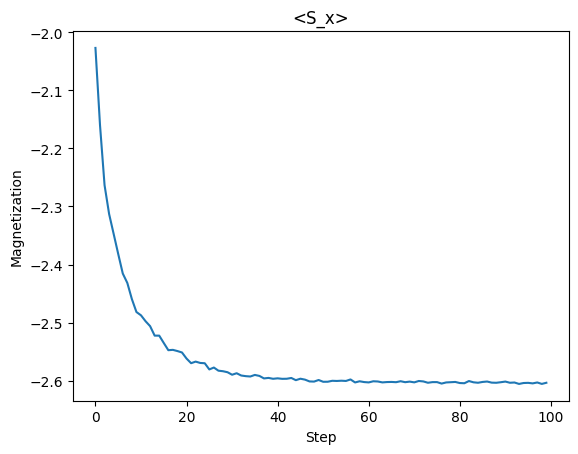

In [ ]:
import numpy as np
import cmath
import numba
import time
from matplotlib import pyplot as plt

@numba.jit
def compute_log_derivative(spin_config, weight_matrix, num_sites):
    """
    Compute the log-derivative matrix of the wavefunction with respect to the weight matrix.
    """
    log_derivative_matrix = np.zeros((num_sites, num_sites), dtype=np.cdouble)
    activation_vector = np.zeros(num_sites, dtype=np.cdouble)

    # Compute the activations for each site
    for site_idx in range(num_sites):
        weighted_sum = 0.0
        for neighbor_idx in range(num_sites):
            weighted_sum += weight_matrix[site_idx][neighbor_idx] * spin_config[neighbor_idx]
        activation_vector[site_idx] = weighted_sum

    # Compute the log-derivative matrix
    log_derivative_matrix = np.outer(np.tanh(activation_vector), spin_config)

    return log_derivative_matrix

@numba.jit
def compute_wavefunction_value(spin_config, weight_matrix, num_sites):
    """
    Compute the value of the wavefunction for a given spin configuration.
    """
    activation_vector = np.zeros(num_sites, dtype=np.cdouble)

    # Calculate the product of cosh(activation) for each site
    for site_idx in range(num_sites):
        weighted_sum = 0.0
        for neighbor_idx in range(num_sites):
            weighted_sum += weight_matrix[site_idx][neighbor_idx] * spin_config[neighbor_idx]
        activation_vector[site_idx] = weighted_sum

    # Compute the wavefunction value
    return np.prod(np.cosh(activation_vector))

@numba.jit
def compute_local_magnetization(spin_config, wavefunction_coeff, weight_matrix, num_sites):
    """
    Compute the local magnetization for a given spin configuration.
    """
    # Local magnetization is the sum of spins in the x-direction for each site
    local_magnetization = 0.0
    for i in range(num_sites):
        local_magnetization += spin_config[i]  # Sum over spin states in x-direction

    flip_magnetization_sum = 0.0
    for i in range(num_sites):
        if spin_config[i] * spin_config[(i + 1) % num_sites] < 0.0:
            flipped_state = spin_config.copy()
            flipped_state[i] *= -1.0
            flipped_state[(i + 1) % num_sites] *= -1.0
            flip_magnetization_sum += compute_wavefunction_value(flipped_state, weight_matrix, num_sites) / wavefunction_coeff

    # Return local magnetization and the effect of spin flips
    return local_magnetization - 0.5 * flip_magnetization_sum

@numba.jit
def metropolis_sampling(weight_matrix, num_sites, num_samples=2000, num_skips=3):

    spin_configuration = np.ones(num_sites)
    spin_configuration[: num_sites // 2] = -1
    spin_configuration *= 0.5
    spin_configuration = spin_configuration[np.random.permutation(num_sites)]

    magnetization_sum = 0.0  # Initialize magnetization sum
    log_derivative_sum = np.zeros((num_sites, num_sites), dtype=np.cdouble)
    magnetization_gradient_product_sum = np.zeros((num_sites, num_sites), dtype=np.cdouble)

    for _ in range(num_samples):
        # Propose new state by flipping spins
        for _ in range(num_skips):
            spin_a = np.random.randint(low=0, high=num_sites)
            spin_b = spin_a
            while spin_configuration[spin_b] * spin_configuration[spin_a] > 0:
                spin_b = np.random.randint(low=0, high=num_sites)

            proposed_configuration = spin_configuration.copy()
            proposed_configuration[spin_a] *= -1.0
            proposed_configuration[spin_b] *= -1.0

            current_wavefunction = compute_wavefunction_value(spin_configuration, weight_matrix, num_sites)
            proposed_wavefunction = compute_wavefunction_value(proposed_configuration, weight_matrix, num_sites)

            # Metropolis acceptance criterion
            if np.random.random() < min(1.0, np.abs(proposed_wavefunction / current_wavefunction)):
                spin_configuration = proposed_configuration.copy()
                current_wavefunction = proposed_wavefunction

        # Compute local magnetization, log derivative, and magnetization-gradient product
        current_magnetization = compute_local_magnetization(spin_configuration, current_wavefunction, weight_matrix, num_sites)
        current_log_derivative = compute_log_derivative(spin_configuration, weight_matrix, num_sites)

        magnetization_sum += current_magnetization
        log_derivative_sum += np.conjugate(current_log_derivative)
        magnetization_gradient_product_sum += np.conjugate(current_log_derivative) * current_magnetization

    return magnetization_gradient_product_sum / num_samples, log_derivative_sum / num_samples, magnetization_sum / num_samples

def optimize_parameters(weight_matrix, num_sites, num_samples, learning_rate):

    steps = []
    magnetizations = []
    start_time = time.time()

    with open("magnetization_jastrow_matrix.txt", "w") as fp:
        for step in range(100):
            ho_sum, log_derivative_sum, average_magnetization = metropolis_sampling(weight_matrix, num_sites, num_samples)
            gradient = 2 * ho_sum - 2 * log_derivative_sum * average_magnetization

            print(f"Step {step}, Magnetization {average_magnetization.real:.4f}")
            fp.write(f"{step}  {average_magnetization.real:.4f}\n")

            steps.append(step)
            magnetizations.append(average_magnetization.real)
            weight_matrix -= learning_rate * gradient

    end_time = time.time()
    print("Elapsed time: %.2f sec" % (end_time - start_time))

    plt.plot(steps, magnetizations)
    plt.xlabel("Step")
    plt.ylabel("Magnetization")
    plt.title("<S_x>")
    plt.show()

if __name__ == '__main__':
    num_sites = 8
    num_samples = 5000
    learning_rate = 0.2
    real_part = np.random.random((num_sites, num_sites))
    imag_part = np.random.random((num_sites, num_sites))
    initial_interaction_matrix = real_part + 1j * imag_part

    optimize_parameters(initial_interaction_matrix, num_sites, num_samples, learning_rate)

